In [1]:
import os
import nibabel as nib

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import tqdm

from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters


In [2]:
base_dir = '/data_nas5/qer/redbrick_project/chest_pe/'
annotators = os.listdir(base_dir)

# Helper functions #

## Functions to extract data from task.json file ##

In [3]:
def task_metadata(task_json_object, annotator_name):
    """Extracts the metadata, including createdBy, createdAt, updatedBy, updatedAt, storageId. returns a pandas dataframe with the metadata

    Args:
        task_json_object (_type_): task json object
    Returns:
        pandas dataframe with the metadata
    """
    num_tasks = len(task_json_object)
    columns = ['createdBy', 'createdAt', 'updatedBy', 'updatedAt', 'storageId']
    columns = [f'{annotator_name}_{column}' for column in columns]
    columns.insert(0, 'name')
    metadata = pd.DataFrame(columns=columns)
    for i in range(num_tasks):
        metadata.loc[i] = [task_json_object[i]['name'],
                           task_json_object[i]['createdBy'],
                           task_json_object[i]['createdAt'],
                           task_json_object[i]['updatedBy'],
                           task_json_object[i]['updatedAt'],
                           task_json_object[i]['storageId']]
    ## Set name as index
    metadata.set_index('name', inplace=True)
    return metadata

In [4]:
def task_status(task_json_object, annotator_name):
    """Extracts the status of the task, including taskId, currentStageName and status
    """
    num_tasks = len(task_json_object)
    columns = ['taskId', 'currentStageName', 'status']
    columns = [f'{annotator_name}_{column}' for column in columns]
    columns.insert(0, 'name')
    status = pd.DataFrame(columns=columns)
    for i in range(num_tasks):
        status.loc[i] = [task_json_object[i]['name'],
                         task_json_object[i]['taskId'],
                         task_json_object[i]['currentStageName'],
                         task_json_object[i]['status']]
    ## Set name as index
    status.set_index('name', inplace=True)
    return status

In [5]:
def task_global_attributes(task_json_object, annotator_name):
    """Extracts the global attributes of the task, including Type, 'Contrast filling defect present in the study', 'Contrast Issue (Too Low/Much)'
    """
    num_tasks = len(task_json_object)
    columns = ['Type', 'UnReadable Scan', 'Contrast Issue (Too Low/Much)', 'Contrast filling defect present in the study']
    columns = [f'{annotator_name}_{column}' for column in columns]
    columns.insert(0, 'name')
    global_attributes = pd.DataFrame(columns=columns)
    for i in range(num_tasks):
        # attributes = task_json_object[i]['classification'].get('attributes', None)
        # if attributes is None:
            # print(f'No attributes for {task_json_object[i]["name"]}, {annotator_name}')
            # attributes = {}
        currentStage = task_json_object[i]['currentStageName']
        status = task_json_object[i]['status']
        if (currentStage == 'Label') or (status == 'PROBLEM'):
            print(f'Current Stage: {currentStage}, status: {status} for {task_json_object[i]["name"]}, {annotator_name}')
            attributes = {'Type': 'Angio'}
        else:
            attributes = task_json_object[i]['classification']['attributes']
        global_attributes.loc[i] = [task_json_object[i]['name'],
                                    # attributes.get('Type', None),
                                    # attributes.get('Contrast filling defect present in the study', False),
                                    # attributes.get('Contrast Issue (Too Low/Much)', False)]
                                    attributes['Type'],
                                    attributes.get('UnReadable Scan', False),
                                    attributes.get('Contrast Issue (Too Low/Much)', False),
                                    attributes.get('Contrast filling defect present in the study', False)]
    ## Set name as index
    global_attributes.set_index('name', inplace=True)
    return global_attributes

In [6]:
## Extract left and right ventricle for the annotators for the images ##
def ventricles_segmentation_map_file(task_json_object, annotator_name):
    num_tasks = len(task_json_object)
    columns = ['Left Ventricle', 'Right Ventricle', 'Mask']
    columns = [f'{annotator_name}_{column}' for column in columns]
    columns.insert(0, 'name')
    ventricles_segment_file = pd.DataFrame(columns=columns)
    for i in range(num_tasks):
        series_info = task_json_object[i]['series'][0]
        if 'segmentMap' not in series_info:
            print(f'Missing segmentMap for {annotator_name}, {task_json_object[i]["name"]}')
            ## Segment maps missing for 6a40a3d189af and fa75aca7d47f
            segment_map_dict = {}
        else:
            segment_map_dict = {}
            ## All the segment maps have keys '1' and '2'. The order of 'Right Ventricle' and 'Left ventricle' are be different across the images
            segment_map_dict[series_info['segmentMap']['1']['category']] = 1
            segment_map_dict[series_info['segmentMap']['2']['category']] = 2
            if series_info['segmentMap']['1']['mask'] != series_info['segmentMap']['2']['mask']:
                print(f'Mask mismatch for {annotator_name}, {task_json_object[i]["name"]}')
            segment_map_dict['Mask'] = series_info['segmentMap']['2']['mask']
        ventricles_segment_file.loc[i] = [task_json_object[i]['name'],
                                          segment_map_dict.get('Left Ventricle', None),
                                          segment_map_dict.get('Right Ventricle', None),
                                          segment_map_dict.get('Mask', None)]
    ventricles_segment_file.set_index('name', inplace=True)
    return ventricles_segment_file

In [7]:
class Point:
    """class to Store x, y, z (position in a 3D array)
    """
    def __init__(self, i, j, k):
        self.i = i
        self.j = j
        self.k = k

    def __repr__(self):
        return f'Point(i={self.i}, j={self.j}, k={self.k})'
    
    def __str__(self):
        return f'Point(i={self.i}, j={self.j}, k={self.k})'

class Cuboid:
    """class to store Cuboid box
    """
    def __init__(self, cuboid_dict):
        self.point1 = Point(**cuboid_dict['point1'])
        self.point2 = Point(**cuboid_dict['point2'])
        self.attributes = cuboid_dict['attributes']

    def k_range(self):
        """Return the k range of the cuboid"""
        if self.is_pe():
            return list(range(self.point1.k, self.point2.k+1))
        else:
            return []

    def is_pe(self):
        ## If self.attibute True PE is True, return True
        return self.attributes.get("True PE", False) 

    def is_confounder(self):
        # return self.attributes.get("Confounder", False)
        if 'Confounder' in self.attributes:
            return True
        else:
            return False

    def confounder_type(self):
        ## If confounder is False, return 0, 1 if Flow Artefact', 2 if 'Motion Aftefact', 3 if 'OTHERS'
        if not self.is_confounder():
            return 0
        else:
            if 'Flow Artefact' in self.attributes['Confounder']:
                return 1
            elif 'Motion Aftefact' in self.attributes['Confounder']:
                return 2
            else:
                return 3

    def intersection(self, other):
        """ Calculate the intersection of self and other """
        return max(0, min(self.point2.i, other.point2.i) - max(self.point1.i, other.point1.i)) * \
               max(0, min(self.point2.j, other.point2.j) - max(self.point1.j, other.point1.j)) * \
               max(0, min(self.point2.k, other.point2.k) - max(self.point1.k, other.point1.k))

    def intersection_cuboid(self, other):
        """ Calculate the intersecting cuboid between self and other """
        ## Check if the cuboids intersect
        if self.intersection(other) == 0:
            return None
        return Cuboid({
            'point1': {
                'i': max(self.point1.i, other.point1.i),
                'j': max(self.point1.j, other.point1.j),
                'k': max(self.point1.k, other.point1.k)
            },
            'point2': {
                'i': min(self.point2.i, other.point2.i),
                'j': min(self.point2.j, other.point2.j),
                'k': min(self.point2.k, other.point2.k)
            },
            'attributes': {"True PE": True}
        })

class CuboidAnnotations:
    """class to store zero or more bboxes annotated
    """
    def __init__(self, cuboid_dict_list):
        self.cuboid_list = [Cuboid(cuboid_dict) for cuboid_dict in cuboid_dict_list]

    def __len__(self):
        return len(self.cuboid_list)
    
    def __getitem__(self, index):
        return self.cuboid_list[index]
    
    def __repr__(self):
        return f'CuboidAnnotations(len={len(self)})'
    
    def __str__(self):
        return f'CuboidAnnotations(len={len(self)})'
    
    def k_range(self):
        """Returns union of k ranges of all the bounding boxes"""
        k_range = []
        for cuboid in self.cuboid_list:
            k_range.extend(cuboid.k_range())
        k_range = list(sorted(set(k_range)))
        return k_range

    def is_pe(self):
        ## Return True if any of tbe cuboid is_pe()
        return any([e.is_pe() for e in self.cuboid_list])

    def num_pes(self):
        return sum([int(e.is_pe()) for e in self.cuboid_list])

    def num_confounders(self):
        return sum([int(e.is_confounder()) for e in self.cuboid_list])

    def pe_cuboids(self):
        return [e for e in self.cuboid_list if e.is_pe()]

    def confounder_cuboids(self):
        return [e for e in self.cuboid_list if e.is_confounder()]

In [8]:
def bboxes_annotations(task_json_object, annotator_name):
    num_tasks = len(task_json_object)
    columns = ['Bounding Box']
    columns = [f'{annotator_name}_{column}' for column in columns]
    columns.insert(0, 'name')
    bboxes_annotations = pd.DataFrame(columns=columns)
    for i in range(num_tasks):
        series_info = task_json_object[i]['series'][0]
        bboxes_annotations.loc[i] = [task_json_object[i]['name'],
                                    CuboidAnnotations(series_info.get('cuboids', []))]
    bboxes_annotations.set_index('name', inplace=True)
    return bboxes_annotations
    

## Function to concatenate all the dataframes on index ##

In [9]:
def concatenate_annotator_level_dataframes(df_list):
    """Concatenates all the dataframes on index

    Args:
        df_list (list): list of dataframes

    Returns:
        concatenated dataframe
    """
    df_list_lengths = [len(df) for df in df_list]
    assert len(set(df_list_lengths)) == 1, "All dataframes must have the same number of rows"
    ## Get the common indices
    indices = set(df_list[0].index)
    for df in df_list[1:]:
        indices = indices.intersection(df.index)
    indices = list(indices)
    assert len(indices) == df_list_lengths[0], "All dataframes must have the same indices"
    df_list_sorted = [df.loc[indices] for df in df_list]
    return pd.concat(df_list_sorted, axis=1)

## Extracting annotations of all anotators for a column ##

In [10]:
def extract_annotations_for_column(df, column_name, annotators):
    """Extracts the annotations for a key for all the annotators

    Args:
        df (_type_): df with annotations from all the annotators
        column_name (_type_): 
        annotators (_type_):
    Returns:
        df with just the annotations for the key for all the annotators
    """
    return_dict = {}
    for annotator in annotators:
        return_dict[annotator.replace('PE_detect_', '')] = df[f'{annotator}_{column_name}']
    return pd.DataFrame(return_dict)


## Functions to extract the ventricles from all annotators ##

In [11]:
def extract_numpy_array_from_nii_file(nii_file_path):
    """Extracts the numpy array from the nii file

    Args:
        nii_file_path (str): path to the nii file
    """
    return nib.load(nii_file_path).get_fdata().transpose(2, 0, 1)

In [12]:
def extract_ventricles_from_annotators(ventricles_df, index_name, column_name, annotators):
    """Extracts the ventricles from all the annotators

    Args:
        ventricles_df (pd.DataFrame): df with the ventricles from all the annotators
        index_name (str): index name to extract the ventricles from
        column_name (str): column name to extract the ventricles from (Either Left Ventricle or Right Ventricle)
        annotators (list): list of annotators
    
    Returns:
        list of numpy arrays, each numpy array a 0-1 mask of the ventricles
    """
    ventricles_list = []
    row = ventricles_df.loc[index_name]
    for annotator in annotators:
        segmentation_map_file = row[f'{annotator}_Mask']
        segmentation_map_file_data = extract_numpy_array_from_nii_file(segmentation_map_file)
        label = row[f'{annotator}_{column_name}']
        ventricles_list.append(segmentation_map_file_data==label)
    return ventricles_list

## Functions to calculate mean of all segmentation maps ##

In [13]:
def mean_of_segmentation_maps(segmap_list):
    """Calculates the mean of all the segmentation maps

    Args:
        segmap_list (list): list of numpy arrays, each numpy array a 0-1 mask of the ventricles
    """
    return np.mean(segmap_list, axis=0)

In [14]:
def mip_along_axis(segmap, axis=0):
    """Calculates the maximum intensity projection along an axis

    Args:
        segmap (np.array): np array of 0-1 segmentaion map
        axis: axis along which to take a mip
    """
    return np.max(segmap, axis=axis)

In [15]:
def iou_with_mean_of_segmentation_maps(segmap_list, threshold=0.5):
    """Calculates the IoU with the mean of all the segmentation maps

    Args:
        segmap_list (list): list of numpy arrays, each numpy array a 0-1 mask of the segmentation
        threshold (float): threshold to use for the mean of all the segmentation maps
    """
    ## First calculate the mean of all the segmentation maps
    mean_segmap = mean_of_segmentation_maps(segmap_list)
    ## Then threshold the mean of all the segmentation maps
    mean_segmap = (mean_segmap>=threshold).astype(int)
    ## Then calculate the IoU with the mean of all the segmentation maps
    iou_list = []
    for segmap in segmap_list:
        intersection = np.sum(mean_segmap*segmap)
        union = np.sum(mean_segmap)+np.sum(segmap)-intersection
        iou_list.append(intersection/union)
    return iou_list

## Functions to create slice level preds from bboxes ##

In [16]:
def create_slice_level_preds_from_bboxes(cuboid_annotations, num_slices):
    """Creates slice level preds from bboxes
    """
    slice_level_preds = np.zeros((num_slices))
    k_ranges = cuboid_annotations.k_range()
    for k_range in k_ranges:
        slice_level_preds[k_range] = 1
    return slice_level_preds

## Functions to calculate non maximum suppression of bounding boxes ##

In [17]:
def intersection_cuboid(cuboid1, cuboid2):
    """Calculates the intersection of two cuboids
    """
    return max(0, min(cuboid1.point2.i, cuboid2.point2.i) - max(cuboid1.point1.i, cuboid2.point1.i)) * \
           max(0, min(cuboid1.point2.j, cuboid2.point2.j) - max(cuboid1.point1.j, cuboid2.point1.j)) * \
           max(0, min(cuboid1.point2.k, cuboid2.point2.k) - max(cuboid1.point1.k, cuboid2.point1.k))

def union_cuboid(cuboid1, cuboid2):
    """Calculates the union of two cuboids
    """
    return (cuboid1.point2.i - cuboid1.point1.i) * \
           (cuboid1.point2.j - cuboid1.point1.j) * \
           (cuboid1.point2.k - cuboid1.point1.k) + \
           (cuboid2.point2.i - cuboid2.point1.i) * \
           (cuboid2.point2.j - cuboid2.point1.j) * \
           (cuboid2.point2.k - cuboid2.point1.k) - \
           intersection_cuboid(cuboid1, cuboid2)

def iou_cuboid(cuboid1, cuboid2):
    """Calculates the IoU of two cuboids
    """
    return intersection_cuboid(cuboid1, cuboid2) / union_cuboid(cuboid1, cuboid2)

In [18]:
def intersection_krange(krange1, krange2):
    """krange1 and krange2 are list of 0 and 1 of same length, with 0 for absence of PE at the index and 1 for presence of PE at the index
    Intersection of krange1 and krange2 is the number of indices where both krange1 and krange2 are 1
    """
    return sum(krange1*krange2)

def union_krange(krange1, krange2):
    """krange1 and krange2 are list of 0 and 1 of same length, with 0 for absence of PE at the index and 1 for presence of PE at the index
    Union of krange1 and krange2 is the number of indices where either krange1 or krange2 is 1
    """
    return sum(krange1) + sum(krange2) - intersection_krange(krange1, krange2)

def iou_krange(krange1, krange2):
    """krange1 and krange2 are list of 0 and 1 of same length, with 0 for absence of PE at the index and 1 for presence of PE at the index
    IoU of krange1 and krange2 is the intersection of krange1 and krange2 divided by the union of krange1 and krange2
    """
    return intersection_krange(krange1, krange2) / union_krange(krange1, krange2)

In [19]:
def filter_peCuboids_cuboidAnnotations_using_majority_voting(cuboidAnnotations_list, filter_iou_threshold=0.5, filter_num_threshold=2):
    """For each cuboidAnnotations in the list, filter the peCuboids which don't have significant overlap with any of the peCuboids from other cuboidAnnotations """
    filtered_peCuboidsAnnotations_list = []
    for cuboidAnnotations_idx, cuboidAnnotations in enumerate(cuboidAnnotations_list):
        filtered_peCuboids = []
        other_cuboidAnnotations_list = [e for i, e in enumerate(cuboidAnnotations_list) if i!=cuboidAnnotations_idx]
        for peCuboid in cuboidAnnotations.pe_cuboids():
            intersection_list = [any([iou_cuboid(peCuboid, other_peCuboid)>=filter_iou_threshold for other_peCuboid in other_cuboidAnnotations.pe_cuboids()]) for other_cuboidAnnotations in other_cuboidAnnotations_list]
            if sum(intersection_list)>=filter_num_threshold:
                filtered_peCuboids.append(peCuboid)
        peCuboidAnnotations_new = CuboidAnnotations([])
        peCuboidAnnotations_new.cuboid_list = filtered_peCuboids
        filtered_peCuboidsAnnotations_list.append(peCuboidAnnotations_new)
    return filtered_peCuboidsAnnotations_list

In [20]:
def filter_peCuboids_cuboidAnnotations_using_gt_krange(cuboidAnnotations, gt_krange, filter_iou_threshold=0.5):
    """Filters the peCuboids which don't have significant overlap with the gt_krange"""
    filtered_peCuboids = []
    for peCuboid in cuboidAnnotations.pe_cuboids():
        pred_krange = create_slice_level_preds_from_bboxes(peCuboid, len(gt_krange))
        # if iou_krange(pred_krange, gt_krange)>=filter_iou_threshold:
        #     filtered_peCuboids.append(peCuboid)
        ## As the gt_krange is very large consisting of all the PEs, we calculate the iou as intersection/length of pred_krange
        intersection = intersection_krange(pred_krange, gt_krange)
        iou_modified = intersection/len(peCuboid.k_range())
        if iou_modified>=filter_iou_threshold:
            filtered_peCuboids.append(peCuboid)
    cuboidAnnotations_new = CuboidAnnotations([])
    cuboidAnnotations_new.cuboid_list = filtered_peCuboids
    return cuboidAnnotations_new


In [56]:
def combine_peCuboidAnnotations_list(cuboidAnnotations_list):
    """Combines a list of cuboidAnnotations into a single cuboidAnnotations
    """
    combined_cuboidAnnotations = CuboidAnnotations([])
    for cuboidAnnotations in cuboidAnnotations_list:
        combined_cuboidAnnotations.cuboid_list.extend(cuboidAnnotations.pe_cuboids())
    return combined_cuboidAnnotations

In [57]:
def index_array_using_cuboid(cuboid):
    """Indexes the array using the cuboid (return slice of the array, not a copy)
    """
    point1_index = np.array([cuboid.point1.k, cuboid.point1.i, cuboid.point1.j])
    point2_index = np.array([cuboid.point2.k, cuboid.point2.i, cuboid.point2.j])
    return point1_index, point2_index
    # return ct_array[point1_index[0]:point2_index[0], point1_index[1]:point2_index[1], point1_index[2]:point2_index[2]]

In [58]:
def calculate_score_array(cuboidAnnotations, ct_shape):
    """Calculates the score array
    """
    score_array = np.zeros(ct_shape)
    for cuboid in cuboidAnnotations.cuboid_list:
        point1_index, point2_index = index_array_using_cuboid(cuboid)
        score_array[point1_index[0]:point2_index[0], point1_index[1]:point2_index[1], point1_index[2]:point2_index[2]] += 1
        # index_array_using_cuboid(score_array, cuboid) += 1
    score_array = score_array/len(cuboidAnnotations.cuboid_list)
    return score_array

def score_cuboids(cuboidAnnotations, score_array=None, ct_shape=None):
    """For each cuboid in the cuboidAnnotations, calculate the score
    The score is calculated as follows:
    - First calculate a score for each voxel in the array of shape ct_shape
        - The score of the voxel is number of cuboids that contain the voxel, divided by the total number of cuboids
    - The the score of the cuboid is the mean of the scores of the voxels that it contains
    
    Args:
        cuboidAnnotations (CuboidAnnotations): cuboidAnnotations, whose cuboids are to be scored
        score_array (np.ndarray): array of shape ct_shape, with the score of the cuboid for each voxel
        ct_shape (tuple): shape of the CT scan
    Returns:
        score_list (list): list of scores for the cuboids
        score_array (np.ndarray): array of shape ct_shape, with the score of the cuboid for each voxel
    """
    ## First calculate the score for each voxel
    if score_array is None:
        if ct_shape is None:
            raise ValueError("Either ct_shape or score_array must be provided") 
        score_array = calculate_score_array(cuboidAnnotations, ct_shape)
    ## Then calculate the score for each cuboid
    score_list = []
    for cuboid in cuboidAnnotations.cuboid_list:
        point1_index, point2_index = index_array_using_cuboid(cuboid)
        score_list.append(np.mean(score_array[point1_index[0]:point2_index[0], point1_index[1]:point2_index[1], point1_index[2]:point2_index[2]]))
    return score_list, score_array

In [59]:
def merge_cuboids_intersection(cuboid_list):
    """Merges the cuboids by taking the intersection of the cuboids"""
    if len(cuboid_list)==1:
        return cuboid_list[0]
    merged_cuboid = cuboid_list[0]
    for cuboid in cuboid_list[1:]:
        merged_cuboid = merged_cuboid.intersection_cuboid(cuboid)
    return merged_cuboid

In [60]:
def non_maximum_suppression_cuboids(cuboid_list, score_list, iou_threshold=0.5):
    """ Iteratively picks the cuboid with the highest score, and picks all cuboids that have an IoU greater than the threshold 
    Then merges the cuboids and returns the merged cuboid """
    nms_cuboid_list = []
    ## First sort the cuboids by score
    sorted_cuboid_list = [x for _, x in sorted(zip(score_list, cuboid_list), key=lambda pair: pair[0], reverse=True)]
    already_picked = np.zeros(len(sorted_cuboid_list))
    ## Then iteratively pick the cuboid with the highest score, and picks all cuboids that have an IoU greater than the threshold 
    for cuboid_idx, cuboid in enumerate(sorted_cuboid_list):
        if already_picked[cuboid_idx]==1:
            continue
        already_picked[cuboid_idx] = 1
        ## Pick all cuboids that have an IoU greater than the threshold
        intersecting_cuboids_list = [cuboid]
        if cuboid_idx+1<len(sorted_cuboid_list):
            for other_cuboid_idx in range(cuboid_idx+1, len(sorted_cuboid_list)):
                if already_picked[other_cuboid_idx]==1:
                    continue
                if iou_cuboid(sorted_cuboid_list[other_cuboid_idx], cuboid)>=iou_threshold:
                    intersecting_cuboids_list.append(sorted_cuboid_list[other_cuboid_idx])
                    already_picked[other_cuboid_idx] = 1
        ## Merge the intersecting cuboids and add to nms_cuboid_list
        merged_cuboid = merge_cuboids_intersection(intersecting_cuboids_list)
        nms_cuboid_list.append(merged_cuboid)
    return nms_cuboid_list

## Functions for calculating inter annotator agreement ##

In [26]:
def apply_map_to_df(df, map_dict):
    """Applies the map_dict to the df

    Args:
        df (pd.DataFrame): df to apply the map_dict to
        map_dict (dict): mapping from categories to numbers
    """
    return df.map(lambda x: map_dict[x])

def apply_inverse_map_to_df(df, map_dict):
    """Applies the inverse of the map_dict to the df

    Args:
        df (pd.DataFrame): df to apply the inverse of the map_dict to
        map_dict (dict): mapping from categories to numbers
    """
    ## First invert the map_dict
    inverse_map_dict = {v: k for k, v in map_dict.items()}
    return df.map(lambda x: inverse_map_dict[x])

In [27]:
def calculate_majority_voting(np_array):
    """Calculates the majority voting for the np_array

    Args:
        np_array (np.ndarray): numpy array of shape (n_tasks, n_annotators), with each element being 0-(N-1) where N is the number of categories
    """
    ## Calculate the majority voting for each row
    majority_voting = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=np_array)
    return majority_voting

In [28]:
def cohens_kappa_with_majority_voting(df, categories_to_num_dict):
    """First calculate the majority voting for each row (which is a task), then calculates the cohen's kappa for the majority voting vs the annotators

    Args:
        df (pd.DataFrame): df with annotations from all the annotators
        categories_to_num_dict (dict): mapping from categories to numbers
    Returns:
        list of cohen's kappa for the majority voting vs the annotators
    """
    # df = df.map(lambda x: categories_to_num_dict[x])
    df_numpy = apply_map_to_df(df, categories_to_num_dict).to_numpy()
    majority_voting = calculate_majority_voting(df_numpy)
    ## For each annotator, calculate the cohen's kappa with the majority voting
    kappas = []
    for i in range(df_numpy.shape[1]):
        kappas.append(cohen_kappa_score(df_numpy[:, i], majority_voting))
    return kappas

In [29]:
def precision_recall_f1_score_with_majority_voting(df, categories_to_num_dict):
    """First calculate the majority voting for each row (which is a task), then calculates the precision, recall and f1 score for the majority voting vs the annotators

    Args:
        df (pd.DataFrame): df with annotations from all the annotators
        categories_to_num_dict (dict): mapping from categories to numbers
    """
    df_numpy = apply_map_to_df(df, categories_to_num_dict).to_numpy()
    majority_voting = calculate_majority_voting(df_numpy)
    ## For each annotator, calculate the precision, recall and f1 score with the majority voting
    precision = []
    recall = []
    f1 = []
    for i in range(df_numpy.shape[1]):
        precision.append(precision_score(df_numpy[:, i], majority_voting, average='macro'))
        recall.append(recall_score(df_numpy[:, i], majority_voting, average='macro'))
        f1.append(f1_score(df_numpy[:, i], majority_voting, average='macro'))
    return precision, recall, f1


In [30]:
def fleiss_kappa_wrapper(df, categories_to_num_dict):
    """Calculate the fleiss kappa for the df

    Args:
        df (pd.DataFrame): df with annotations from all the annotators
        categories_to_num_dict (dict): mapping from categories to numbers

    Returns:
        float: fleiss kappa
    """
    df = df.map(lambda x: categories_to_num_dict[x])
    df_numpy = df.to_numpy()
    arr, _ = aggregate_raters(df_numpy)
    return fleiss_kappa(arr)

## CT Viewer class ##

In [31]:
class CTViewer:
    """
    View a volumetric CT image using widgets in ipython notebooks. This class builds
    upon ImageSliceViewer3D (https://github.com/mohakpatel/ImageSliceViewer3D).
    
    The orientation, slice numbers, and CT windows can be changed interactively.
    
    Arguments
    volume: A volumetric CT image converted to Hounsfield units (HU)
    figsize: Size of the figure to be plotted. Defaults to (8, 8)
    """
    
    def __init__(self, volume, figsize=(8,8)):
        self.volume = volume
        self.figsize = figsize
        self.v = [np.min(volume), np.max(volume)]
        self.last_known_slice_z = 0
        self.last_known_slice_y = 0
        self.last_known_slice_x = 0
        self.last_thresh_x=-np.inf
        self.last_thresh_y=-np.inf
        self.last_thresh_z=-np.inf
        self.t_z=False
        self.t_y=False
        self.t_x=False
        ## z, x, y orientation originally
        self.orientations = {"z-y":[0,2,1],
                             "z-x":[0,1,2],
                             "x-y": [1,2,0]}
        self.recompute_window(window_param=None)
        self.last_window = None
        self.windows = {"None": [None, None], 
                        "Bone" : [500, 2000],
                        "Lung": [-600, 1600],
                        "Abdomen": [40, 400],
                        "Brain": [30, 70],
                        "Soft Tissue": [50, 350],
                        "Liver": [60, 160],
                        "Mediastinum": [50, 500],
                        "Stroke": [30, 30],
                        "CTA": [170, 600]}

        ipyw.interact(self.check_if_custom_window,
                    #   view=ipyw.RadioButtons(
                    #       options=list(self.orientations.keys()),
                    #       value='x-y', 
                    #       description='Slice plane selection:',
                    #       disabled=False,
                    #       style={'description_width': 'initial'}), 
                      window=ipyw.Dropdown(
                          options=list(self.windows)  + ['Custom'],
                          value='None', 
                          description='CT Window:',
                          disabled=False,
                          style={'description_width': 'initial'}),
                      window_level=ipyw.fixed(None),
                      window_width=ipyw.fixed(None))
    
    def recompute_window(self,window_param=None):
        clip_vol = self.volume
        if window_param is not None:
            assert isinstance(window_param,tuple)
            clip_vol = np.clip(self.volume,window_param[1],window_param[0])
        self.vol = {
            "z-y": np.transpose(clip_vol, self.orientations["z-y"]),
            "z-x": np.transpose(clip_vol, self.orientations["z-x"]),
            "x-y": np.transpose(clip_vol, self.orientations["x-y"]),
        }
        self.v = {
            "z-y": [np.min(self.vol['z-y']),np.max(self.vol['z-y'])],
            "z-x": [np.min(self.vol['z-x']),np.max(self.vol['z-x'])],
            "x-y": [np.min(self.vol['x-y']),np.max(self.vol['x-y'])],
        }
        # plt.text(0,0.1,f"min: {clip_vol.min()}, max: {clip_vol.max()}, window_param {window_param}")
        self.last_thresh_x=self.v['x-y'][0]
        self.last_thresh_y=self.v['z-x'][0]
        self.last_thresh_z=self.v['z-y'][0]

        
    def check_if_custom_window(self, window):
        """
        Function to handle the "Custom" option in the window selection dropdown.
        """
        ipyw.interact(self.view_selection,
                    #   view=ipyw.fixed(view), 
                      window=ipyw.fixed(window),
                      window_level=ipyw.IntText(
                          value=2000,
                          description='Window_level:',
                          disabled=False) if window == "Custom" else ipyw.fixed(None),
                      window_width=ipyw.IntText(
                          value=4000,
                          description='Window_width:',
                          disabled=False) if window == "Custom" else ipyw.fixed(None))

    def view_selection(self, window, window_level=None, window_width=None):
        """
        Process the volume according to the selected values for view and window.
        """
        
        # Transpose the volume according to selected view
        # self.vol = np.transpose(self.volume, self.orientations[view])
        maxZ = self.vol['x-y'].shape[2] - 1
        maxY = self.vol['z-x'].shape[2] - 1
        maxX = self.vol['z-y'].shape[2] - 1
        
        # CT Windowing

        # plt.text(0,0.2,f"{window}")
        upd=False
        if window != "None":
            if window != "Custom":
                window_level, window_width = self.windows[window]
            # plt.text(0,0.3,f"window_level: {window_level}, window_width: {window_width}")
            if self.last_window is not None:
                if not (window_level==self.last_window[0] and window_width==self.last_window[1]):
                    upd = True
            else:
                upd=True
            upper, lower = window_level + window_width//2, window_level - window_width//2
            # self.vol = np.clip(self.vol, lower, upper)            
            self.recompute_window(window_param = (upper,lower))
            self.last_window = [window_width,window_level]
        # self.v = [np.min(self.vol), np.max(self.vol)]


        ipyw.interact(
            self.plot_slice, 
            z=ipyw.IntSlider(min=0,
                            max=maxZ,
                            value=self.last_known_slice_z,
                            step=1,
                            continuous_update=False,
                            description='Slice z:'),
            y=ipyw.IntSlider(min=0,
                            max=maxY,
                            value=self.last_known_slice_y,
                            step=1,
                            continuous_update=False,
                            description='Slice y:'),
            x=ipyw.IntSlider(min=0,
                            max=maxX,
                            value=self.last_known_slice_x,
                            step=1,
                            continuous_update=False,
                            description='Slice x:'),
            t_z = ipyw.Checkbox(
                value=self.t_z,
                description="t_z",
            ),
            t_y = ipyw.Checkbox(
                value=self.t_y,
                description="t_y",
            ),
            t_x = ipyw.Checkbox(
                value=self.t_x,
                description="t_x",
            ),
            thresh_z=ipyw.FloatSlider(
                min=self.v['x-y'][0],
                max=self.v['x-y'][1],
                value=self.last_thresh_z,
                step=0.1,
                description='thresh_z',
                disabled=self.t_z,
                continuous_update=False,),
            thresh_y=ipyw.FloatSlider(
                    min=self.v['z-x'][0],
                    max=self.v['z-x'][1],
                    value=self.last_thresh_y,
                    step=0.1,
                    description='thresh_y',
                    disabled=self.t_y,
                    continuous_update=False,),
            thresh_x=ipyw.FloatSlider(
                    min=self.v['z-y'][0],
                    max=self.v['z-y'][1],
                    value=self.last_thresh_x,
                    step=0.1,
                    description='thresh_x',
                    disabled=self.t_x,
                    continuous_update=False,),
                )

        
    def plot_slice(self, z,y,x,t_z,t_y,t_x,thresh_z,thresh_y,thresh_x):
        """
        Plot the selected slice.
        """
        self.last_known_slice_z = z
        self.last_known_slice_y = y
        self.last_known_slice_x = x
        self.last_thresh_z=thresh_z
        self.last_thresh_y=thresh_y
        self.last_thresh_x=thresh_x

        # self.fig = plt.figure(figsize=self.figsize)
        fig, ax = plt.subplots(1, 3, figsize=(self.figsize[0],self.figsize[1]*3), squeeze=False)
        
        slice_z = self.vol['x-y'][:,:,z]
        if t_z:
            slice_z = slice_z>thresh_z
            ax[0,0].imshow(slice_z,cmap="gray")
        else:
            ax[0,0].imshow(slice_z,
                    cmap='gray', 
                    vmin=self.v['x-y'][0],
                    vmax=self.v['x-y'][1])
        
        slize_y = self.vol['z-x'][:,:,y]
        if t_y:
            slize_y = slize_y>thresh_y
            ax[0,1].imshow(slize_y,cmap="gray")
        else:
            ax[0,1].imshow(slize_y,
                    cmap='gray', 
                    vmin=self.v['z-x'][0],
                    vmax=self.v['z-x'][1])
        slice_x = self.vol['z-y'][:,:,x]
        if t_x:
            slice_x = slice_x>thresh_x
            ax[0,2].imshow(slice_x,cmap="gray")
        else:
            ax[0,2].imshow(slice_x,
                    cmap='gray', 
                    vmin=self.v['z-y'][0],
                    vmax=self.v['z-y'][1])

# Reading the task json objects #

In [32]:
task_json_object_list = [json.load(open(f'{base_dir}/{annotator}/tasks.json')) for annotator in annotators]

In [33]:
## The following tasks were reported as problems, so the currentStage == Label and status == PROBLEM or unreadable scans
problem_tasks_with_stageLabel = ['6a40a3d189af', '60801eca6a7a',
                                 'fa75aca7d47f', '574d1fa9e7be', 'c2c039f601b7',
                                 '0e429ff3a5a7', '8e0a8819c826', '1c9231c79657', 'bc855cd8bdc9']

# Scan level analysis #

## Extracting data to pandas dataframe ##

In [75]:
task_metadata_df_list = [task_metadata(task_json_object, annotator) for task_json_object, annotator in zip(task_json_object_list, annotators)]
task_metadata_df = concatenate_annotator_level_dataframes(task_metadata_df_list)
task_metadata_df.head()

,PE_detect_DrSuyash_createdBy,PE_detect_DrSuyash_createdAt,PE_detect_DrSuyash_updatedBy,PE_detect_DrSuyash_updatedAt,PE_detect_DrSuyash_storageId,PE_detect_DrArindam_createdBy,PE_detect_DrArindam_createdAt,PE_detect_DrArindam_updatedBy,PE_detect_DrArindam_updatedAt,PE_detect_DrArindam_storageId,...,PE_detect_DrTapender_createdBy,PE_detect_DrTapender_createdAt,PE_detect_DrTapender_updatedBy,PE_detect_DrTapender_updatedAt,PE_detect_DrTapender_storageId,PE_detect_DrGanesh_createdBy,PE_detect_DrGanesh_createdAt,PE_detect_DrGanesh_updatedBy,PE_detect_DrGanesh_updatedAt,PE_detect_DrGanesh_storageId
name,,,,,,,,,,,,,,,,,,,,,
f7dc547cb4b2,redbrick@qure.ai,2025-03-13T13:03:26.694600+00:00,suyashgunjal541@gmail.com,2025-03-31T20:00:12.731093+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:03:13.393881+00:00,mukherjeearindam455@gmail.com,2025-03-30T17:32:20.343424+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,...,redbrick@qure.ai,2025-03-13T13:00:11.394301+00:00,dr.tapender@anolytics.in,2025-03-27T12:59:34.962609+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:02:51.474332+00:00,g31729984@gmail.com,2025-03-31T07:35:09.916903+00:00,850a953b-14fa-4d15-9511-1857e49f6e32
b63a373f18b8,redbrick@qure.ai,2025-03-13T13:03:26.700765+00:00,suyashgunjal541@gmail.com,2025-04-02T04:39:34.266416+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:03:13.400011+00:00,mukherjeearindam455@gmail.com,2025-03-29T16:25:14.503174+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,...,redbrick@qure.ai,2025-03-13T13:00:11.400798+00:00,dr.tapender@anolytics.in,2025-03-27T12:59:34.829454+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:02:51.480578+00:00,g31729984@gmail.com,2025-03-31T18:00:44.708717+00:00,850a953b-14fa-4d15-9511-1857e49f6e32
6153370af2e8,redbrick@qure.ai,2025-03-13T13:03:26.686731+00:00,suyashgunjal541@gmail.com,2025-04-01T22:42:41.383659+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:03:13.386035+00:00,mukherjeearindam455@gmail.com,2025-03-27T04:37:32.851484+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,...,redbrick@qure.ai,2025-03-13T13:00:11.386016+00:00,dr.tapender@anolytics.in,2025-03-27T12:59:34.147741+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:02:51.466426+00:00,g31729984@gmail.com,2025-03-31T14:09:41.817687+00:00,850a953b-14fa-4d15-9511-1857e49f6e32
a5ad89a78764,redbrick@qure.ai,2025-03-13T13:03:26.704802+00:00,suyashgunjal541@gmail.com,2025-04-01T21:03:26.828979+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:03:13.404099+00:00,mukherjeearindam455@gmail.com,2025-03-19T12:40:57.850799+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,...,redbrick@qure.ai,2025-03-13T13:00:11.404994+00:00,dr.tapender@anolytics.in,2025-03-27T12:59:34.823173+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:02:51.484614+00:00,g31729984@gmail.com,2025-04-01T02:32:46.398455+00:00,850a953b-14fa-4d15-9511-1857e49f6e32
42fcfc49f03e,redbrick@qure.ai,2025-03-13T13:03:26.668728+00:00,suyashgunjal541@gmail.com,2025-03-29T06:44:23.218808+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:03:13.368135+00:00,mukherjeearindam455@gmail.com,2025-03-26T03:59:39.841279+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,...,redbrick@qure.ai,2025-03-13T13:00:11.366058+00:00,dr.tapender@anolytics.in,2025-03-27T12:59:34.739157+00:00,850a953b-14fa-4d15-9511-1857e49f6e32,redbrick@qure.ai,2025-03-13T13:02:51.448589+00:00,g31729984@gmail.com,2025-03-31T03:31:23.388620+00:00,850a953b-14fa-4d15-9511-1857e49f6e32


In [76]:
status_df_list = [task_status(task_json_object, annotator) for task_json_object, annotator in zip(task_json_object_list, annotators)]
status_df = concatenate_annotator_level_dataframes(status_df_list)
status_df.head()

,PE_detect_DrSuyash_taskId,PE_detect_DrSuyash_currentStageName,PE_detect_DrSuyash_status,PE_detect_DrArindam_taskId,PE_detect_DrArindam_currentStageName,PE_detect_DrArindam_status,PE_detect_DrRekha_taskId,PE_detect_DrRekha_currentStageName,PE_detect_DrRekha_status,PE_detect_DrSaurabh_taskId,...,PE_detect_DrPuran_status,PE_detect_DrRahul_taskId,PE_detect_DrRahul_currentStageName,PE_detect_DrRahul_status,PE_detect_DrTapender_taskId,PE_detect_DrTapender_currentStageName,PE_detect_DrTapender_status,PE_detect_DrGanesh_taskId,PE_detect_DrGanesh_currentStageName,PE_detect_DrGanesh_status
name,,,,,,,,,,,,,,,,,,,,,
f7dc547cb4b2,ae6a0be0-6ac5-40bb-826a-5938a1c5708c,Review_1,UNASSIGNED,84553a60-91d9-4093-8fe3-d1eaca7f2e61,Review_1,UNASSIGNED,c567a822-cab7-43ce-aaca-2c2714036d5a,Review_1,UNASSIGNED,c4706dad-4182-460a-8fbd-517f349ce84b,...,UNASSIGNED,16275439-9276-412b-998c-09b36d0eadb1,Review_1,UNASSIGNED,785412da-9d06-4d1e-ace3-c1eb4af798ad,Review_1,UNASSIGNED,23c078b8-f184-4c3f-880d-4be8ea427f09,Review_1,UNASSIGNED
b63a373f18b8,b3cba861-0de2-452f-ada9-55d69afb8cab,Review_1,UNASSIGNED,759114d6-f22a-4df0-ad9c-b84030ba819a,Review_1,UNASSIGNED,385796c6-bab2-44e8-bd69-3f24d8a38825,Review_1,UNASSIGNED,ba4ae443-2a0f-4abf-8151-0caedc86277d,...,UNASSIGNED,e4abb0c8-aae2-4183-bdef-c52efd3db9d8,Review_1,UNASSIGNED,ffcbcd48-720b-43e6-9fa9-43c381113777,Review_1,UNASSIGNED,27b7536c-0bc1-4218-8b78-85e2f7058040,Review_1,UNASSIGNED
6153370af2e8,41efec62-488f-413f-860b-455e819db0ea,Review_1,UNASSIGNED,4eba21dc-6120-4f7b-98f9-17d04fcfa75f,Review_1,UNASSIGNED,3142b0be-8548-4575-b478-8f0eacd897a1,Review_1,UNASSIGNED,c56644ae-7859-4ea2-8954-f52652ffec9f,...,UNASSIGNED,8ab24ac8-c135-4a26-b4e6-6fa604bd30fe,Review_1,UNASSIGNED,10d31d27-61cf-4e0b-b458-dc3983f4f36e,Review_1,UNASSIGNED,424139a8-3fd7-45dd-8430-eedcfd22c5d6,Review_1,UNASSIGNED
a5ad89a78764,07942f1f-a54a-4caa-af70-fdb887dbabdd,Review_1,UNASSIGNED,8ad0dec8-53ea-4359-82b7-8594f3b887d4,Review_1,UNASSIGNED,032973dd-5af7-4810-83ef-f42d3bf117a6,Review_1,UNASSIGNED,3b098564-87ff-46c5-a735-e019eeea2d43,...,UNASSIGNED,51536949-8da4-467d-813f-2d059d713406,Review_1,UNASSIGNED,6c6c7f30-13fe-4eca-b575-fc1e3754cdc7,Review_1,UNASSIGNED,dc9e2bd5-c43a-408b-9fb2-3437f0f98458,Review_1,UNASSIGNED
42fcfc49f03e,efc328fb-7449-482e-b786-eec5790741ca,Review_1,UNASSIGNED,195cdebf-ae1d-411b-b99d-7967c9efc80a,Review_1,UNASSIGNED,33621478-6b1e-4a73-87dd-997e3dae6de8,Review_1,UNASSIGNED,cc52d768-8a38-4b40-b208-c154317fc8d3,...,UNASSIGNED,0e5f5223-b665-4430-a18e-cbef54b74441,Review_1,UNASSIGNED,741e91c0-a412-49cf-a91d-42561aa7fc00,Review_1,UNASSIGNED,8e5196c8-ec7e-452c-b271-85ade1cc0819,Review_1,UNASSIGNED


In [77]:
global_attributes_df_list = [task_global_attributes(task_json_object, annotator) for task_json_object, annotator in zip(task_json_object_list, annotators)]
global_attributes_df = concatenate_annotator_level_dataframes(global_attributes_df_list)
global_attributes_df.head()

Current Stage: Label, status: PROBLEM for 6a40a3d189af, PE_detect_DrSuyash
Current Stage: Label, status: PROBLEM for 60801eca6a7a, PE_detect_DrSuyash
Current Stage: Label, status: PROBLEM for fa75aca7d47f, PE_detect_DrTapender
Current Stage: Label, status: PROBLEM for 574d1fa9e7be, PE_detect_DrTapender
Current Stage: Label, status: PROBLEM for 6a40a3d189af, PE_detect_DrTapender
Current Stage: Label, status: PROBLEM for c2c039f601b7, PE_detect_DrTapender
Current Stage: Label, status: PROBLEM for fa75aca7d47f, PE_detect_DrGanesh
Current Stage: Label, status: PROBLEM for 6a40a3d189af, PE_detect_DrGanesh


,PE_detect_DrSuyash_Type,PE_detect_DrSuyash_UnReadable Scan,PE_detect_DrSuyash_Contrast Issue (Too Low/Much),PE_detect_DrSuyash_Contrast filling defect present in the study,PE_detect_DrArindam_Type,PE_detect_DrArindam_UnReadable Scan,PE_detect_DrArindam_Contrast Issue (Too Low/Much),PE_detect_DrArindam_Contrast filling defect present in the study,PE_detect_DrRekha_Type,PE_detect_DrRekha_UnReadable Scan,...,PE_detect_DrRahul_Contrast Issue (Too Low/Much),PE_detect_DrRahul_Contrast filling defect present in the study,PE_detect_DrTapender_Type,PE_detect_DrTapender_UnReadable Scan,PE_detect_DrTapender_Contrast Issue (Too Low/Much),PE_detect_DrTapender_Contrast filling defect present in the study,PE_detect_DrGanesh_Type,PE_detect_DrGanesh_UnReadable Scan,PE_detect_DrGanesh_Contrast Issue (Too Low/Much),PE_detect_DrGanesh_Contrast filling defect present in the study
name,,,,,,,,,,,,,,,,,,,,,
f7dc547cb4b2,Contrast,False,False,True,Contrast,False,False,True,Contrast,False,...,False,True,Contrast,False,False,True,Angio,False,False,True
b63a373f18b8,Angio,False,False,True,Angio,False,False,True,Angio,False,...,False,True,Angio,False,False,True,Angio,False,False,True
6153370af2e8,Contrast,False,False,True,Contrast,False,False,True,Contrast,False,...,False,True,Angio,False,False,True,Angio,False,False,True
a5ad89a78764,Angio,False,False,True,Angio,False,False,False,Angio,False,...,False,True,Contrast,False,False,False,Angio,False,False,True
42fcfc49f03e,Contrast,False,False,True,Angio,False,False,False,Contrast,False,...,False,True,Contrast,False,False,True,Angio,False,False,True


## Filtering out tasks with stage: Label, or status: PROBLEM, or unreadable scans ##

In [78]:
## Filter out task_metadata_df, status_df, global_attributes_df for these tasks
task_metadata_filtered_df = task_metadata_df.loc[~task_metadata_df.index.isin(problem_tasks_with_stageLabel)]
status_filtered_df = status_df.loc[~status_df.index.isin(problem_tasks_with_stageLabel)]
global_attributes_filtered_df = global_attributes_df.loc[~global_attributes_df.index.isin(problem_tasks_with_stageLabel)]

### Extracting the unreadable scans ###

In [79]:
current_stage_name_df = extract_annotations_for_column(status_filtered_df, 'currentStageName', annotators)
# current_stage_name_df.head()
current_stage_name_df.value_counts()

DrSuyash  DrArindam  DrRekha   DrSaurabh  DrArun    DrShalini  DrPuran   DrRahul   DrTapender  DrGanesh
Review_1  Review_1   Review_1  Review_1   Review_1  Review_1   Review_1  Review_1  Review_1    Review_1    51
Name: count, dtype: int64

In [80]:
unreadable_scan_df = extract_annotations_for_column(global_attributes_filtered_df, 'UnReadable Scan', annotators)
# unreadable_scan_df.head()
unreadable_scan_df.value_counts()

DrSuyash  DrArindam  DrRekha  DrSaurabh  DrArun  DrShalini  DrPuran  DrRahul  DrTapender  DrGanesh
False     False      False    False      False   False      False    False    False       False       51
Name: count, dtype: int64

In [81]:
## For each annotator, find indices where unreadable_scan_df is True
unreadable_scan_names = set()
for i, annotator in enumerate(annotators):
    unreadable_scan_names.update(unreadable_scan_df[unreadable_scan_df[annotator.replace('PE_detect_', '')] == True].index)

In [82]:
# unreadable_scans_names = ['1c9231c79657', '0e429ff3a5a7', '8e0a8819c826', 'bc855cd8bdc9']
unreadable_scans_names = list(unreadable_scan_names)
unreadable_scans_names

[]

In [83]:
## Filter out task_metadata_filtered_df, status_filtered_df, global_attributes_filtered_df for these tasks
task_metadata_filtered_df = task_metadata_filtered_df.loc[~task_metadata_filtered_df.index.isin(unreadable_scans_names)]
status_filtered_df = status_filtered_df.loc[~status_filtered_df.index.isin(unreadable_scans_names)]
global_attributes_filtered_df = global_attributes_filtered_df.loc[~global_attributes_filtered_df.index.isin(unreadable_scans_names)]

In [84]:
current_stage_name_df = extract_annotations_for_column(status_filtered_df, 'currentStageName', annotators)
unreadable_scan_df = extract_annotations_for_column(global_attributes_filtered_df, 'UnReadable Scan', annotators)

### Summary of the removed scans ###

In [85]:
#6a40a3d189af - Thick slices/slices not in order
#60801eca6a7a - Vessels not visible, type contrast
#fa75aca7d47f - Scan is non contrast
#574d1fa9e7be - Very low contrast
#c2c039f601b7 - Thick slices/slices not in order
#0e429ff3a5a7 - Contrast too low marked by DrSaurabh only
#8e0a8819c826 - Contrast too low marked by DrSaurabh only
#bc855cd8bdc9 - Contrast too low marked by DrSaurabh only, PE marked by Dr Tapendra
#1c9231c79657 - Contrast too low marked by DrSaurabh, DrArun, DrShalini and DrRahul. Not issue by others

## Inter annotator analysis for task level data (Type, Contrast Filling defect present, Contrast value too low/high) ##

### Analysis for Type ###

In [86]:
type_df = extract_annotations_for_column(global_attributes_filtered_df, 'Type', annotators)
type_df.head()

,DrSuyash,DrArindam,DrRekha,DrSaurabh,DrArun,DrShalini,DrPuran,DrRahul,DrTapender,DrGanesh
name,,,,,,,,,,
f7dc547cb4b2,Contrast,Contrast,Contrast,Angio,Angio,Contrast,Angio,Angio,Contrast,Angio
b63a373f18b8,Angio,Angio,Angio,Angio,Angio,Angio,Angio,Angio,Angio,Angio
6153370af2e8,Contrast,Contrast,Contrast,Angio,Contrast,Contrast,Contrast,Contrast,Angio,Angio
a5ad89a78764,Angio,Angio,Angio,Angio,Angio,Angio,Contrast,Angio,Contrast,Angio
42fcfc49f03e,Contrast,Angio,Contrast,Angio,Contrast,Contrast,Contrast,Contrast,Contrast,Angio


In [87]:
## Calculate the fleiss kappa and cohen's kappa for the type analysis
fleis_kappa_type = fleiss_kappa_wrapper(type_df, {'Angio': 0, 'Contrast': 1})
cohens_kappa_list = cohens_kappa_with_majority_voting(type_df, {'Angio': 0, 'Contrast': 1})
print("Fleiss kappa: ", fleis_kappa_type)
for i, kappa in enumerate(cohens_kappa_list):
    print(f"Cohen's kappa for {type_df.columns[i]}: {kappa}")

Fleiss kappa:  0.1730436643588009
Cohen's kappa for DrSuyash: 0.27192386131883073
Cohen's kappa for DrArindam: 0.5292307692307692
Cohen's kappa for DrRekha: 0.34928229665071764
Cohen's kappa for DrSaurabh: 0.0
Cohen's kappa for DrArun: 0.6338461538461538
Cohen's kappa for DrShalini: 0.18450184501845024
Cohen's kappa for DrPuran: 0.653061224489796
Cohen's kappa for DrRahul: 0.4930417495029822
Cohen's kappa for DrTapender: 0.368141592920354
Cohen's kappa for DrGanesh: 0.0


In [88]:
categories_to_num_dict = {'Angio': 0, 'Contrast': 1}
df_numpy = apply_map_to_df(type_df, categories_to_num_dict).to_numpy()
majority_voting = pd.Series(calculate_majority_voting(df_numpy), index=type_df.index)
majority_voting = majority_voting.map({0: 'Angio', 1: 'Contrast'})
type_df_temp = type_df.copy()
type_df_temp['majority_voting'] = majority_voting

## DrGanesh, DrSaurabh marked all scans as Angio
type_df_temp[['DrSaurabh', 'DrGanesh', 'majority_voting']]


,DrSaurabh,DrGanesh,majority_voting
name,,,
f7dc547cb4b2,Angio,Angio,Angio
b63a373f18b8,Angio,Angio,Angio
6153370af2e8,Angio,Angio,Contrast
a5ad89a78764,Angio,Angio,Angio
42fcfc49f03e,Angio,Angio,Contrast
d9e7f4891acd,Angio,Angio,Angio
881175d3c694,Angio,Angio,Angio
63e54ad464f4,Angio,Angio,Angio
f19ff247be53,Angio,Angio,Angio


In [89]:
type_df_temp['majority_voting'].value_counts()

majority_voting
Angio       41
Contrast    10
Name: count, dtype: int64

In [90]:
## Fliess kappa after dropping DrSaurabh and DrGanesh
type_df_new = type_df.drop(columns=['DrSaurabh', 'DrGanesh'])
fleiss_kappa_type_new = fleiss_kappa_wrapper(type_df_new, {'Angio': 0, 'Contrast': 1})
cohens_kappa_list_new = cohens_kappa_with_majority_voting(type_df_new, {'Angio': 0, 'Contrast': 1})
print("Fleiss kappa: ", fleiss_kappa_type_new)
for i, kappa in enumerate(cohens_kappa_list_new):
    print(f"Cohen's kappa for {type_df_new.columns[i]}: {kappa}")

Fleiss kappa:  0.2741523040847151
Cohen's kappa for DrSuyash: 0.5206073752711496
Cohen's kappa for DrArindam: 0.5984251968503937
Cohen's kappa for DrRekha: 0.6807511737089202
Cohen's kappa for DrArun: 0.5091863517060367
Cohen's kappa for DrShalini: 0.3004115226337448
Cohen's kappa for DrPuran: 0.4426229508196722
Cohen's kappa for DrRahul: 0.5595854922279793
Cohen's kappa for DrTapender: 0.5812807881773399


### Analysis for Contrast filling defect ###

In [91]:
contrast_filling_defect_df = extract_annotations_for_column(global_attributes_filtered_df, 'Contrast filling defect present in the study', annotators)
contrast_filling_defect_df.head()

,DrSuyash,DrArindam,DrRekha,DrSaurabh,DrArun,DrShalini,DrPuran,DrRahul,DrTapender,DrGanesh
name,,,,,,,,,,
f7dc547cb4b2,True,True,True,True,True,True,True,True,True,True
b63a373f18b8,True,True,True,True,True,True,True,True,True,True
6153370af2e8,True,True,True,True,True,True,True,True,True,True
a5ad89a78764,True,False,True,True,True,True,True,True,False,True
42fcfc49f03e,True,False,True,True,True,True,True,True,True,True


In [92]:
fleiss_kappa_contrast_filling_defect = fleiss_kappa_wrapper(contrast_filling_defect_df, {False: 0, True: 1})
cohens_kappa_list = cohens_kappa_with_majority_voting(contrast_filling_defect_df, {False: 0, True: 1})
print("Fleiss kappa: ", fleiss_kappa_contrast_filling_defect)
for i, kappa in enumerate(cohens_kappa_list):
    print(f"Cohen's kappa for {contrast_filling_defect_df.columns[i]}: {kappa}")

Fleiss kappa:  0.5172039041994749
Cohen's kappa for DrSuyash: 0.9215384615384615
Cohen's kappa for DrArindam: 0.3325635103926097
Cohen's kappa for DrRekha: 0.8425925925925926
Cohen's kappa for DrSaurabh: 0.8042977743668458
Cohen's kappa for DrArun: 0.7268553940321346
Cohen's kappa for DrShalini: 0.6871165644171779
Cohen's kappa for DrPuran: 0.8036951501154734
Cohen's kappa for DrRahul: 0.6450116009280742
Cohen's kappa for DrTapender: 0.7638888888888888
Cohen's kappa for DrGanesh: 0.5714285714285714


In [93]:
categories_to_num_dict = {False: 0, True: 1}
df_numpy = apply_map_to_df(contrast_filling_defect_df, categories_to_num_dict).to_numpy()
majority_voting = pd.Series(calculate_majority_voting(df_numpy), index=contrast_filling_defect_df.index)
majority_voting = majority_voting.map({0: False, 1: True})
contrast_filling_defect_df_temp = contrast_filling_defect_df.copy()
contrast_filling_defect_df_temp['majority_voting'] = majority_voting

contrast_filling_defect_df_temp[['DrSuyash', 'DrGanesh', 'DrArindam', 'majority_voting']]

,DrSuyash,DrGanesh,DrArindam,majority_voting
name,,,,
f7dc547cb4b2,True,True,True,True
b63a373f18b8,True,True,True,True
6153370af2e8,True,True,True,True
a5ad89a78764,True,True,False,True
42fcfc49f03e,True,True,False,True
d9e7f4891acd,False,False,True,False
881175d3c694,False,False,True,False
63e54ad464f4,False,True,False,False
f19ff247be53,True,True,True,True


In [94]:
## fleiss kappa after removing DrArindam, DrGanesh from columns
contrast_filling_defect_new_df = contrast_filling_defect_df.drop(columns=['DrArindam', 'DrGanesh'])
fleiss_kappa_contrast_filling_defect_new = fleiss_kappa_wrapper(contrast_filling_defect_new_df, {False: 0, True: 1})
cohens_kappa_list_new = cohens_kappa_with_majority_voting(contrast_filling_defect_new_df, {False: 0, True: 1})
print("Fleiss kappa: ", fleiss_kappa_contrast_filling_defect_new)
for i, kappa in enumerate(cohens_kappa_list_new):
    print(f"Cohen's kappa for {contrast_filling_defect_new_df.columns[i]}: {kappa}")

Fleiss kappa:  0.599092970521542
Cohen's kappa for DrSuyash: 0.9215384615384615
Cohen's kappa for DrRekha: 0.8425925925925926
Cohen's kappa for DrSaurabh: 0.8042977743668458
Cohen's kappa for DrArun: 0.7268553940321346
Cohen's kappa for DrShalini: 0.6871165644171779
Cohen's kappa for DrPuran: 0.8036951501154734
Cohen's kappa for DrRahul: 0.6450116009280742
Cohen's kappa for DrTapender: 0.7638888888888888


In [95]:
## Calculate precision, recall and f1 score for the contrast filling defect analysis
precision, recall, f1 = precision_recall_f1_score_with_majority_voting(contrast_filling_defect_new_df, categories_to_num_dict)
for i, annotator_name in enumerate(contrast_filling_defect_new_df.columns):
    print(f"Precision for {annotator_name}: {precision[i]}")
    print(f"Recall for {annotator_name}: {recall[i]}")
    print(f"F1 score for {annotator_name}: {f1[i]}")

Precision for DrSuyash: 0.9607692307692308
Recall for DrSuyash: 0.9607692307692308
F1 score for DrSuyash: 0.9607692307692308
Precision for DrRekha: 0.9199999999999999
Recall for DrRekha: 0.9333333333333333
F1 score for DrRekha: 0.920807453416149
Precision for DrSaurabh: 0.9030769230769231
Recall for DrSaurabh: 0.9068322981366459
F1 score for DrSaurabh: 0.9018097805159799
Precision for DrArun: 0.8653846153846154
Recall for DrArun: 0.890625
F1 score for DrArun: 0.8608187134502924
Precision for DrShalini: 0.8446153846153847
Recall for DrShalini: 0.8510971786833856
F1 score for DrShalini: 0.8425925925925926
Precision for DrPuran: 0.9015384615384616
Recall for DrPuran: 0.9027777777777777
F1 score for DrPuran: 0.9018097805159799
Precision for DrRahul: 0.8207692307692308
Recall for DrRahul: 0.851010101010101
F1 score for DrRahul: 0.8190776507686244
Precision for DrTapender: 0.8807692307692307
Recall for DrTapender: 0.8928571428571428
F1 score for DrTapender: 0.8812111801242236


### Analysis for Contrast too low/high ###

In [ ]:
contrast_issue_df = extract_annotations_for_column(global_attributes_filtered_df, 'Contrast Issue (Too Low/Much)', annotators)
contrast_issue_df.head()

In [ ]:
for col in contrast_issue_df.columns:
    print(contrast_issue_df[col].value_counts())

In [ ]:
fleiss_kappa_contrast_issue = fleiss_kappa_wrapper(contrast_issue_df, {False: 0, True: 1})
cohens_kappa_list = cohens_kappa_with_majority_voting(contrast_issue_df, {False: 0, True: 1})
print("Fleiss kappa: ", fleiss_kappa_contrast_issue)
for i, kappa in enumerate(cohens_kappa_list):
    print(f"Cohen's kappa for {contrast_issue_df.columns[i]}: {kappa}")

In [ ]:
## Check majority voting ##
categories_to_num_dict = {False: 0, True: 1}
df_numpy = apply_map_to_df(contrast_issue_df, categories_to_num_dict).to_numpy()
majority_voting = pd.Series(calculate_majority_voting(df_numpy), index=contrast_issue_df.index)
majority_voting = majority_voting.map({0: False, 1: True})
contrast_issue_df_temp = contrast_issue_df.copy()
contrast_issue_df_temp['majority_voting'] = majority_voting
contrast_issue_df_temp['majority_voting']

# Ventricles Segmentation Analysis #

## Extracting data to pandas dataframe ##

In [96]:
# task_metadata_df_list = [task_metadata(task_json_object, annotator) for task_json_object, annotator in zip(task_json_object_list, annotators)]
ventricles_segment_file_df_list = [ventricles_segmentation_map_file(task_json_object, annotator) for task_json_object, annotator in zip(task_json_object_list, annotators)]
ventricles_segment_file_df = concatenate_annotator_level_dataframes(ventricles_segment_file_df_list)
ventricles_segment_file_df.head()

Missing segmentMap for PE_detect_DrSuyash, 6a40a3d189af
Missing segmentMap for PE_detect_DrTapender, fa75aca7d47f
Missing segmentMap for PE_detect_DrGanesh, fa75aca7d47f
Missing segmentMap for PE_detect_DrGanesh, 6a40a3d189af


,PE_detect_DrSuyash_Left Ventricle,PE_detect_DrSuyash_Right Ventricle,PE_detect_DrSuyash_Mask,PE_detect_DrArindam_Left Ventricle,PE_detect_DrArindam_Right Ventricle,PE_detect_DrArindam_Mask,PE_detect_DrRekha_Left Ventricle,PE_detect_DrRekha_Right Ventricle,PE_detect_DrRekha_Mask,PE_detect_DrSaurabh_Left Ventricle,...,PE_detect_DrPuran_Mask,PE_detect_DrRahul_Left Ventricle,PE_detect_DrRahul_Right Ventricle,PE_detect_DrRahul_Mask,PE_detect_DrTapender_Left Ventricle,PE_detect_DrTapender_Right Ventricle,PE_detect_DrTapender_Mask,PE_detect_DrGanesh_Left Ventricle,PE_detect_DrGanesh_Right Ventricle,PE_detect_DrGanesh_Mask
name,,,,,,,,,,,,,,,,,,,,,
f7dc547cb4b2,1,2,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,1,2,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,...,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...
b63a373f18b8,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,...,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...
6153370af2e8,1,2,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,1,2,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,...,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...
a5ad89a78764,1,2,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,1,2,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,...,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...
42fcfc49f03e,1,2,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,1,2,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,...,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...,2,1,/data_nas5/qer/redbrick_project/chest_pe/PE_de...


## Filtering out tasks with stage: Label, or status: PROBLEM, or unreadable scans ##

In [97]:
ventricles_segment_file_filtered_df = ventricles_segment_file_df.loc[~ventricles_segment_file_df.index.isin(problem_tasks_with_stageLabel)]

## Inter annotator analysis for ventricles segmentation ##

### IoU, MIP IoU and slices IOU analysis for a single image ###

In [ ]:
ventricles_list = extract_ventricles_from_annotators(ventricles_segment_file_filtered_df, '297e99581050', 'Left Ventricle', annotators)
iou_list = iou_with_mean_of_segmentation_maps(ventricles_list, threshold=0.3)
for i, iou in enumerate(iou_list):
    print(f"IoU for {annotators[i]}: {iou}")

In [ ]:
CTViewer(ventricles_list[1], figsize=(20, 20))

In [ ]:
flattened_ventricles = [mip_along_axis(e, 0) for e in ventricles_list]
iou_list = iou_with_mean_of_segmentation_maps(flattened_ventricles, threshold=0.5)
for i, iou in enumerate(iou_list):
    print(f"IoU for {annotators[i]}: {iou}")

In [ ]:
## Displaying the flattened ventricles ##
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i, annotator in enumerate(annotators):
    ax[i//2, i%2].imshow(flattened_ventricles[i], cmap='gray')
    ax[i//2, i%2].set_title(f'Flattened Ventricles for {annotator}')
plt.show()

In [ ]:
slices_annotated_list = [mip_along_axis(e, (1, 2)) for e in ventricles_list]
iou_list = iou_with_mean_of_segmentation_maps(slices_annotated_list, threshold=0.3)
for i, iou in enumerate(iou_list):
    print(f"IoU for {annotators[i]}: {iou}")

In [ ]:
## Displaying the slices annotated list ##
min_slice_idx_annotated_list = [np.where(slices_annotated_list[i] == 1)[0][0] for i in range(len(slices_annotated_list))]
max_slice_idx_annotated_list = [np.where(slices_annotated_list[i] == 1)[0][-1] for i in range(len(slices_annotated_list))]
min_slice_idx = min(min_slice_idx_annotated_list)
max_slice_idx = max(max_slice_idx_annotated_list)

fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i, annotator in enumerate(annotators):
    ## slices_annotated_list[i] is a 1D array, with 1s on slices where the annotator has annotated the ventricles
    ## Plot the 1D array as a horizontal bar chart
    ax[i//2, i%2].bar(range(min_slice_idx, max_slice_idx), slices_annotated_list[i][min_slice_idx:max_slice_idx])
    ax[i//2, i%2].set_title(f'Slices Annotated for {annotator}')
plt.show()


### IoU, MIP IoU and slices IOU analysis for all the images ###

In [98]:
## Do the iou analysis for all the images ##
lv_iou_list_dict, lv_flattened_iou_list_dict, lv_slices_annotated_list_dict = {}, {}, {}
for name in tqdm.tqdm(ventricles_segment_file_filtered_df.index):
    ventricles_list = extract_ventricles_from_annotators(ventricles_segment_file_filtered_df, name, 'Left Ventricle', annotators)
    flattened_ventricles = [mip_along_axis(e, 0) for e in ventricles_list]
    slices_annotated_list = [mip_along_axis(e, (1, 2)) for e in ventricles_list]
    lv_iou_list_dict[name] = iou_with_mean_of_segmentation_maps(ventricles_list, threshold=0.3)
    lv_flattened_iou_list_dict[name] = iou_with_mean_of_segmentation_maps(flattened_ventricles, threshold=0.5)
    lv_slices_annotated_list_dict[name] = iou_with_mean_of_segmentation_maps(slices_annotated_list, threshold=0.3)

## Convert the dict of lists to a dataframe
lv_iou_df = pd.DataFrame(lv_iou_list_dict).transpose().set_axis([e.replace('PE_detect_', '') for e in annotators], axis=1)
lv_flattened_iou_df = pd.DataFrame(lv_flattened_iou_list_dict).transpose().set_axis([e.replace('PE_detect_', '') for e in annotators], axis=1)
lv_slices_annotated_df = pd.DataFrame(lv_slices_annotated_list_dict).transpose().set_axis([e.replace('PE_detect_', '') for e in annotators], axis=1)

  0%|          | 0/51 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# lv_iou_df.head()
# lv_flattened_iou_df.head()
# lv_slices_annotated_df.head()

In [ ]:
## Calculate the mean IoUs for each annotator ##
for i, annotator in enumerate([e.replace('PE_detect_', '') for e in annotators]):
    print(f"{annotator}: {lv_iou_df[annotator].mean()}, {lv_flattened_iou_df[annotator].mean()}, {lv_slices_annotated_df[annotator].mean()}")

In [ ]:
rv_iou_list_dict, rv_flattened_iou_list_dict, rv_slices_annotated_list_dict = {}, {}, {}
for name in tqdm.tqdm(ventricles_segment_file_filtered_df.index):
    ventricles_list = extract_ventricles_from_annotators(ventricles_segment_file_filtered_df, name, 'Right Ventricle', annotators)
    flattened_ventricles = [mip_along_axis(e, 0) for e in ventricles_list]
    slices_annotated_list = [mip_along_axis(e, (1, 2)) for e in ventricles_list]
    rv_iou_list_dict[name] = iou_with_mean_of_segmentation_maps(ventricles_list, threshold=0.3)
    rv_flattened_iou_list_dict[name] = iou_with_mean_of_segmentation_maps(flattened_ventricles, threshold=0.5)
    rv_slices_annotated_list_dict[name] = iou_with_mean_of_segmentation_maps(slices_annotated_list, threshold=0.3)

## Convert the dict of lists to a dataframe
rv_iou_df = pd.DataFrame(rv_iou_list_dict).transpose().set_axis([e.replace('PE_detect_', '') for e in annotators], axis=1)
rv_flattened_iou_df = pd.DataFrame(rv_flattened_iou_list_dict).transpose().set_axis([e.replace('PE_detect_', '') for e in annotators], axis=1)
rv_slices_annotated_df = pd.DataFrame(rv_slices_annotated_list_dict).transpose().set_axis([e.replace('PE_detect_', '') for e in annotators], axis=1)

In [ ]:
for i, annotator in enumerate([e.replace('PE_detect_', '') for e in annotators]):
    print(f"{annotator}: {rv_iou_df[annotator].mean()}, {rv_flattened_iou_df[annotator].mean()}, {rv_slices_annotated_df[annotator].mean()}")

# PE bounding box analysis #

## Extracting data to pandas dataframe ##

In [99]:
bboxes_annotations_df_list = [bboxes_annotations(task_json_object, annotator) for task_json_object, annotator in zip(task_json_object_list, annotators)]
bboxes_annotations_df = concatenate_annotator_level_dataframes(bboxes_annotations_df_list)
bboxes_annotations_df.head().astype(str)

,PE_detect_DrSuyash_Bounding Box,PE_detect_DrArindam_Bounding Box,PE_detect_DrRekha_Bounding Box,PE_detect_DrSaurabh_Bounding Box,PE_detect_DrArun_Bounding Box,PE_detect_DrShalini_Bounding Box,PE_detect_DrPuran_Bounding Box,PE_detect_DrRahul_Bounding Box,PE_detect_DrTapender_Bounding Box,PE_detect_DrGanesh_Bounding Box
name,,,,,,,,,,
f7dc547cb4b2,CuboidAnnotations(len=2),CuboidAnnotations(len=5),CuboidAnnotations(len=4),CuboidAnnotations(len=3),CuboidAnnotations(len=4),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=5),CuboidAnnotations(len=2),CuboidAnnotations(len=2)
b63a373f18b8,CuboidAnnotations(len=2),CuboidAnnotations(len=3),CuboidAnnotations(len=4),CuboidAnnotations(len=2),CuboidAnnotations(len=3),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=4),CuboidAnnotations(len=2),CuboidAnnotations(len=2)
6153370af2e8,CuboidAnnotations(len=1),CuboidAnnotations(len=3),CuboidAnnotations(len=1),CuboidAnnotations(len=1),CuboidAnnotations(len=1),CuboidAnnotations(len=1),CuboidAnnotations(len=2),CuboidAnnotations(len=1),CuboidAnnotations(len=1),CuboidAnnotations(len=1)
a5ad89a78764,CuboidAnnotations(len=1),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=4),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=1)
42fcfc49f03e,CuboidAnnotations(len=8),CuboidAnnotations(len=6),CuboidAnnotations(len=2),CuboidAnnotations(len=4),CuboidAnnotations(len=4),CuboidAnnotations(len=5),CuboidAnnotations(len=2),CuboidAnnotations(len=6),CuboidAnnotations(len=3),CuboidAnnotations(len=3)


## Filtering out tasks with stage: Label, or status: PROBLEM, or unreadable scans ##

In [100]:
bboxes_annotations_filtered_df = bboxes_annotations_df.loc[~bboxes_annotations_df.index.isin(problem_tasks_with_stageLabel)]

## Extracting the ground truths ##

In [101]:
study_level_gt_csv = '/raid1/qCT_PE/csvs/combined_open_source_data_25_01_25.csv'
study_level_gt_df = pd.read_csv(study_level_gt_csv)
study_level_gt_df = study_level_gt_df[study_level_gt_df['study_uid'].isin(bboxes_annotations_filtered_df.index)]
study_level_gt_df.set_index('study_uid', inplace=True, drop=True)
study_level_gt_df = study_level_gt_df.loc[bboxes_annotations_filtered_df.index]


study_level_gt_df.head()

,gt,type,path,dataset
name,,,,
f7dc547cb4b2,1,train,/raid1/qCT_PE/RSNA_PE/train_safetensors/,rsna
b63a373f18b8,1,train,/raid1/qCT_PE/RSNA_PE/train_safetensors/,rsna
6153370af2e8,1,val,/raid1/qCT_PE/RSNA_PE/train_safetensors/,rsna
a5ad89a78764,1,train,/raid1/qCT_PE/RSNA_PE/train_safetensors/,rsna
42fcfc49f03e,1,train,/raid1/qCT_PE/RSNA_PE/train_safetensors/,rsna


In [102]:
study_level_gt_df['gt'].value_counts()

gt
1    41
0    10
Name: count, dtype: int64

In [103]:
slice_level_gt_csv = '/raid1/qCT_PE/csvs/slices_data_with_study_info_and_split_09_02_25.csv'
slice_level_gt_df = pd.read_csv(slice_level_gt_csv)
slice_level_gt_df = slice_level_gt_df[slice_level_gt_df['study_uid'].isin(bboxes_annotations_filtered_df.index)]
slice_level_gt_df.head()

,study_uid,slice_num,gt,type,acute_pe,chronic_pe,acute_and_chronic_pe,central_pe,rightsided_pe,leftsided_pe,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,indeterminate,flow_artifact,true_filling_defect_not_pe,pos_slices_count
110820,4795d5a157dc,0,0,train,0,0,0,0,0,0,0,0,0,0,0,0
110821,4795d5a157dc,1,0,train,0,0,0,0,0,0,0,0,0,0,0,0
110822,4795d5a157dc,2,0,train,0,0,0,0,0,0,0,0,0,0,0,0
110823,4795d5a157dc,3,0,train,0,0,0,0,0,0,0,0,0,0,0,0
110824,4795d5a157dc,4,0,train,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
## For each index, need to change the slice_num to num_slices - slice_num
slice_level_gt_df['num_slices'] = slice_level_gt_df.groupby('study_uid')['slice_num'].transform('count')
slice_level_gt_df['slice_num'] = slice_level_gt_df['num_slices'] - slice_level_gt_df['slice_num']
## Sort each study_uid group by slice_num
slice_level_gt_df = slice_level_gt_df.sort_values(by=['study_uid', 'slice_num'])
slice_level_gt_df.head()

,study_uid,slice_num,gt,type,acute_pe,chronic_pe,acute_and_chronic_pe,central_pe,rightsided_pe,leftsided_pe,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,indeterminate,flow_artifact,true_filling_defect_not_pe,pos_slices_count,num_slices
1559578,01f27ef0f65b,1,0,val,1,0,0,0,1,0,0,1,0,1,0,4,235
1559577,01f27ef0f65b,2,0,val,1,0,0,0,1,0,0,1,0,1,0,4,235
1559576,01f27ef0f65b,3,0,val,1,0,0,0,1,0,0,1,0,1,0,4,235
1559575,01f27ef0f65b,4,0,val,1,0,0,0,1,0,0,1,0,1,0,4,235
1559574,01f27ef0f65b,5,0,val,1,0,0,0,1,0,0,1,0,1,0,4,235


## Inter annotator analysis for PE bounding box analysis ##

### Study level precision, recall and f1 score with ground truth ###

In [105]:
study_level_pe_df = bboxes_annotations_filtered_df.map(lambda x : x.is_pe())
study_level_pe_df.astype(int).head()

,PE_detect_DrSuyash_Bounding Box,PE_detect_DrArindam_Bounding Box,PE_detect_DrRekha_Bounding Box,PE_detect_DrSaurabh_Bounding Box,PE_detect_DrArun_Bounding Box,PE_detect_DrShalini_Bounding Box,PE_detect_DrPuran_Bounding Box,PE_detect_DrRahul_Bounding Box,PE_detect_DrTapender_Bounding Box,PE_detect_DrGanesh_Bounding Box
name,,,,,,,,,,
f7dc547cb4b2,1,1,1,1,1,1,1,1,1,1
b63a373f18b8,1,1,1,1,1,1,1,1,1,1
6153370af2e8,1,1,0,1,0,1,1,1,1,1
a5ad89a78764,1,1,1,1,1,1,1,1,1,1
42fcfc49f03e,1,1,1,1,1,1,1,1,1,1


In [106]:
fleiss_kappa_study_level_pe = fleiss_kappa_wrapper(study_level_pe_df, {False: 0, True: 1})
cohens_kappa_list = cohens_kappa_with_majority_voting(study_level_pe_df, {False: 0, True: 1})
print("Fleiss kappa: ", fleiss_kappa_study_level_pe)
for i, kappa in enumerate(cohens_kappa_list):
    print(f"Cohen's kappa for {study_level_pe_df.columns[i]}: {kappa}")

Fleiss kappa:  0.7349040436011055
Cohen's kappa for PE_detect_DrSuyash_Bounding Box: 1.0
Cohen's kappa for PE_detect_DrArindam_Bounding Box: 0.8811188811188811
Cohen's kappa for PE_detect_DrRekha_Bounding Box: 0.7289293849658314
Cohen's kappa for PE_detect_DrSaurabh_Bounding Box: 0.9209302325581395
Cohen's kappa for PE_detect_DrArun_Bounding Box: 0.8045977011494253
Cohen's kappa for PE_detect_DrShalini_Bounding Box: 0.7238979118329466
Cohen's kappa for PE_detect_DrPuran_Bounding Box: 0.9607390300230947
Cohen's kappa for PE_detect_DrRahul_Bounding Box: 0.9209302325581395
Cohen's kappa for PE_detect_DrTapender_Bounding Box: 0.8827586206896552
Cohen's kappa for PE_detect_DrGanesh_Bounding Box: 0.64


In [45]:
study_level_num_pe_df = bboxes_annotations_filtered_df.map(lambda x : x.num_pes())
study_level_num_pe_df.head()

,PE_detect_DrSuyash_Bounding Box,PE_detect_DrArindam_Bounding Box,PE_detect_DrRekha_Bounding Box,PE_detect_DrSaurabh_Bounding Box,PE_detect_DrArun_Bounding Box,PE_detect_DrShalini_Bounding Box,PE_detect_DrPuran_Bounding Box,PE_detect_DrRahul_Bounding Box,PE_detect_DrTapender_Bounding Box,PE_detect_DrGanesh_Bounding Box
name,,,,,,,,,,
f7dc547cb4b2,2,5,4,3,4,2,2,5,2,2
b63a373f18b8,2,3,4,2,2,2,2,4,2,2
6153370af2e8,1,3,0,1,0,1,2,1,1,1
a5ad89a78764,1,2,2,2,4,2,2,2,2,1
42fcfc49f03e,8,6,2,4,1,5,2,6,3,3


In [46]:
study_level_num_confounders_df = bboxes_annotations_filtered_df.map(lambda x : x.num_confounders())
study_level_num_confounders_df.describe()

,PE_detect_DrSuyash_Bounding Box,PE_detect_DrArindam_Bounding Box,PE_detect_DrRekha_Bounding Box,PE_detect_DrSaurabh_Bounding Box,PE_detect_DrArun_Bounding Box,PE_detect_DrShalini_Bounding Box,PE_detect_DrPuran_Bounding Box,PE_detect_DrRahul_Bounding Box,PE_detect_DrTapender_Bounding Box,PE_detect_DrGanesh_Bounding Box
count,51.0,51.000000,51.000000,51.0,51.000000,51.000000,51.000000,51.000000,51.000000,51.0
mean,0.0,0.137255,0.058824,0.0,0.411765,0.058824,0.019608,0.039216,0.058824,0.0
std,0.0,0.400979,0.310597,0.0,0.753033,0.237635,0.140028,0.196039,0.237635,0.0
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,0.0,2.000000,2.000000,0.0,3.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [107]:
## Get precision, recall and f1 score for study level PE detection with ground truth ##
precision_list, recall_list, f1_list = [], [], []
for i, annotator in enumerate(study_level_pe_df.columns):
    precision_list.append(precision_score(study_level_gt_df['gt'], study_level_pe_df[annotator].map({False: 0, True: 1})))
    recall_list.append(recall_score(study_level_gt_df['gt'], study_level_pe_df[annotator].map({False: 0, True: 1})))
    f1_list.append(f1_score(study_level_gt_df['gt'], study_level_pe_df[annotator].map({False: 0, True: 1})))

print("annotator, precision, recall, f1")
for i, annotator in enumerate(study_level_pe_df.columns):
    print(f"{annotator.replace('PE_detect_', '').replace('_Bounding Box', '')}, {precision_list[i]}, {recall_list[i]}, {f1_list[i]}")

annotator, precision, recall, f1
DrSuyash, 0.9629629629629629, 0.6341463414634146, 0.7647058823529411
DrArindam, 0.9333333333333333, 0.6829268292682927, 0.7887323943661971
DrRekha, 1.0, 0.4878048780487805, 0.6557377049180327
DrSaurabh, 0.9655172413793104, 0.6829268292682927, 0.8
DrArun, 1.0, 0.5853658536585366, 0.7384615384615385
DrShalini, 1.0, 0.6829268292682927, 0.8115942028985508
DrPuran, 1.0, 0.6341463414634146, 0.7761194029850746
DrRahul, 0.9310344827586207, 0.6585365853658537, 0.7714285714285715
DrTapender, 0.9583333333333334, 0.5609756097560976, 0.7076923076923077
DrGanesh, 0.8529411764705882, 0.7073170731707317, 0.7733333333333333


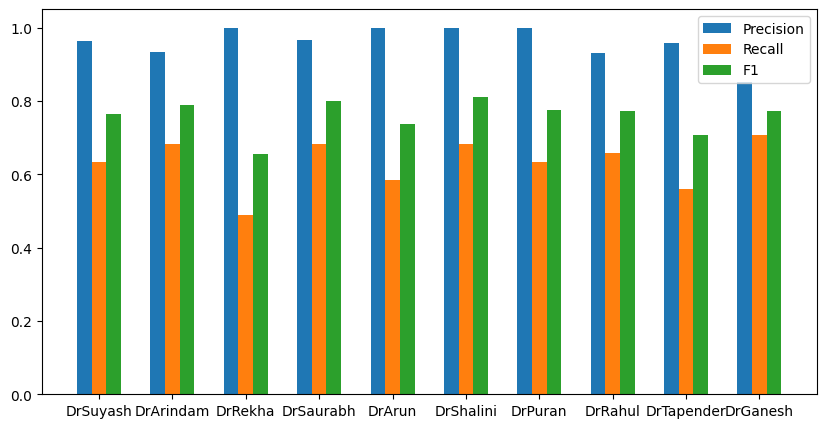

In [108]:
precision_recall_f1_df = pd.DataFrame({'annotator': study_level_pe_df.columns, 'precision': precision_list, 'recall': recall_list, 'f1': f1_list})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w, x = 0.2, np.arange(len(precision_recall_f1_df))
ax.bar(x-w, precision_recall_f1_df['precision'], width=w, label='Precision')
ax.bar(x, precision_recall_f1_df['recall'], width=w, label='Recall')
ax.bar(x+w, precision_recall_f1_df['f1'], width=w, label='F1')

ax.set_xticks(x)
ax.set_xticklabels([e.replace('PE_detect_', '').replace('_Bounding Box', '') for e in precision_recall_f1_df['annotator']])
ax.legend()
plt.show()

### Slice level precision, recall and f1 score with ground truth ###

In [109]:
name_slices_level_pred_df_list = []
for name in bboxes_annotations_filtered_df.index:
    name_slices_level_gt_df = slice_level_gt_df[slice_level_gt_df['study_uid'] == name][['study_uid', 'slice_num', 'gt']].copy(deep=True)
    num_slices = len(name_slices_level_gt_df)
    for annotator in bboxes_annotations_filtered_df.columns:
        name_slices_level_gt_df[annotator.replace('PE_detect_', '').replace('_Bounding Box', '')] = create_slice_level_preds_from_bboxes(bboxes_annotations_filtered_df.loc[name][annotator], num_slices)
    name_slices_level_pred_df_list.append(name_slices_level_gt_df)
name_slices_level_pred_df = pd.concat(name_slices_level_pred_df_list)
name_slices_level_pred_df.head()

,study_uid,slice_num,gt,DrSuyash,DrArindam,DrRekha,DrSaurabh,DrArun,DrShalini,DrPuran,DrRahul,DrTapender,DrGanesh
1287201,f7dc547cb4b2,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1287200,f7dc547cb4b2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1287199,f7dc547cb4b2,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1287198,f7dc547cb4b2,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1287197,f7dc547cb4b2,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
## Calculate precision, recall and f1 score for slice level PE detection with ground truth ##
precision_list, recall_list, f1_list = [], [], []
annotator_list = [e for e in name_slices_level_pred_df.columns if e not in ['study_uid', 'slice_num', 'gt']]
for annotator in annotator_list:
    if annotator in ['study_uid', 'slice_num', 'gt']:
        continue
    precision_list.append(precision_score(name_slices_level_pred_df['gt'], name_slices_level_pred_df[annotator]))
    recall_list.append(recall_score(name_slices_level_pred_df['gt'], name_slices_level_pred_df[annotator]))
    f1_list.append(f1_score(name_slices_level_pred_df['gt'], name_slices_level_pred_df[annotator]))

print("annotator, precision, recall, f1")
i = 0
for annotator in annotator_list:
    if annotator in ['study_uid', 'slice_num', 'gt']:
        continue
    print(f"{annotator}, {precision_list[i]}, {recall_list[i]}, {f1_list[i]}")
    i += 1

annotator, precision, recall, f1
DrSuyash, 0.7484276729559748, 0.6795146324054246, 0.7123082678638234
DrArindam, 0.7317581653926337, 0.7516059957173448, 0.7415492957746479
DrRekha, 0.8338870431893688, 0.5374732334047109, 0.6536458333333334
DrSaurabh, 0.8103294746215495, 0.6495360456816559, 0.7210776545166403
DrArun, 0.7704194260485652, 0.4982155603140614, 0.6051148677936714
DrShalini, 0.7017678708685626, 0.6516773733047823, 0.6757957068837898
DrPuran, 0.7480499219968799, 0.6845110635260528, 0.7148714125978383
DrRahul, 0.8271103896103896, 0.7273376159885796, 0.7740220281048233
DrTapender, 0.7256944444444444, 0.596716630977873, 0.6549157853505679
DrGanesh, 0.7442084942084942, 0.550321199143469, 0.6327451784981535


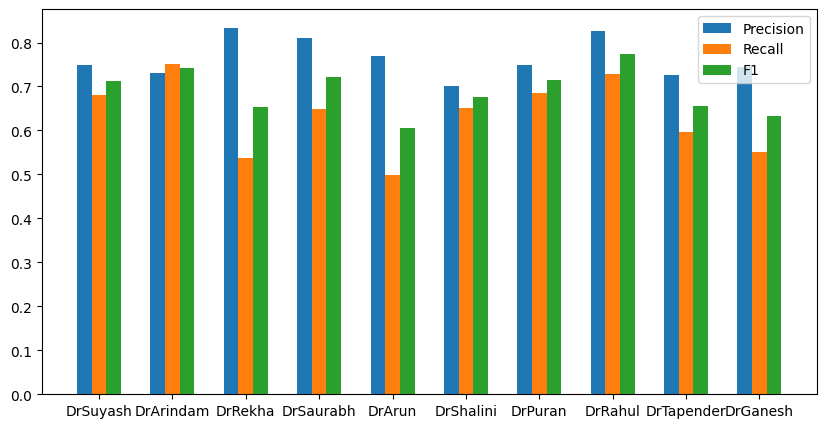

In [111]:
precision_recall_f1_df = pd.DataFrame({'annotator': annotator_list, 'precision': precision_list, 'recall': recall_list, 'f1': f1_list})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w, x = 0.2, np.arange(len(precision_recall_f1_df))
ax.bar(x-w, precision_recall_f1_df['precision'], width=w, label='Precision')
ax.bar(x, precision_recall_f1_df['recall'], width=w, label='Recall')
ax.bar(x+w, precision_recall_f1_df['f1'], width=w, label='F1')

ax.set_xticks(x)
ax.set_xticklabels([e.replace('PE_detect_', '').replace('_Bounding Box', '') for e in precision_recall_f1_df['annotator']])
ax.legend()
plt.show()

### Misc ###

In [112]:
bboxes_annotations_filtered_df.head().astype(str)

,PE_detect_DrSuyash_Bounding Box,PE_detect_DrArindam_Bounding Box,PE_detect_DrRekha_Bounding Box,PE_detect_DrSaurabh_Bounding Box,PE_detect_DrArun_Bounding Box,PE_detect_DrShalini_Bounding Box,PE_detect_DrPuran_Bounding Box,PE_detect_DrRahul_Bounding Box,PE_detect_DrTapender_Bounding Box,PE_detect_DrGanesh_Bounding Box
name,,,,,,,,,,
f7dc547cb4b2,CuboidAnnotations(len=2),CuboidAnnotations(len=5),CuboidAnnotations(len=4),CuboidAnnotations(len=3),CuboidAnnotations(len=4),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=5),CuboidAnnotations(len=2),CuboidAnnotations(len=2)
b63a373f18b8,CuboidAnnotations(len=2),CuboidAnnotations(len=3),CuboidAnnotations(len=4),CuboidAnnotations(len=2),CuboidAnnotations(len=3),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=4),CuboidAnnotations(len=2),CuboidAnnotations(len=2)
6153370af2e8,CuboidAnnotations(len=1),CuboidAnnotations(len=3),CuboidAnnotations(len=1),CuboidAnnotations(len=1),CuboidAnnotations(len=1),CuboidAnnotations(len=1),CuboidAnnotations(len=2),CuboidAnnotations(len=1),CuboidAnnotations(len=1),CuboidAnnotations(len=1)
a5ad89a78764,CuboidAnnotations(len=1),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=4),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=2),CuboidAnnotations(len=1)
42fcfc49f03e,CuboidAnnotations(len=8),CuboidAnnotations(len=6),CuboidAnnotations(len=2),CuboidAnnotations(len=4),CuboidAnnotations(len=4),CuboidAnnotations(len=5),CuboidAnnotations(len=2),CuboidAnnotations(len=6),CuboidAnnotations(len=3),CuboidAnnotations(len=3)


In [119]:
def volume_of_cuboid(cuboid):
    return (cuboid.point2.i - cuboid.point1.i) * (cuboid.point2.j - cuboid.point1.j) * (cuboid.point2.k - cuboid.point1.k)

def mean_volume_of_cuboid_list(cuboid_list):
    if len(cuboid_list) == 0:
        return 0
    return sum([volume_of_cuboid(cuboid) for cuboid in cuboid_list]) / len(cuboid_list)



In [121]:
mean_volumes = bboxes_annotations_filtered_df.map(lambda x : mean_volume_of_cuboid_list(x.pe_cuboids())) / (512 * 512)
mean_volumes.head()

,PE_detect_DrSuyash_Bounding Box,PE_detect_DrArindam_Bounding Box,PE_detect_DrRekha_Bounding Box,PE_detect_DrSaurabh_Bounding Box,PE_detect_DrArun_Bounding Box,PE_detect_DrShalini_Bounding Box,PE_detect_DrPuran_Bounding Box,PE_detect_DrRahul_Bounding Box,PE_detect_DrTapender_Bounding Box,PE_detect_DrGanesh_Bounding Box
name,,,,,,,,,,
f7dc547cb4b2,0.758682,0.223676,0.365353,0.584305,0.145237,1.420303,2.431763,0.232397,0.321905,0.944927
b63a373f18b8,0.984375,0.908878,0.344795,1.031902,0.839893,2.015293,2.000553,0.302204,1.656675,1.189177
6153370af2e8,0.014980,0.016202,0.000000,0.043304,0.000000,0.306908,0.021355,0.120605,0.132935,0.138771
a5ad89a78764,0.598824,0.472181,0.158005,0.162708,0.033372,0.241968,0.136917,0.112267,0.244028,0.196896
42fcfc49f03e,0.029295,0.028083,0.026781,0.022938,0.017372,0.097539,0.493748,0.014547,0.102306,0.015272


In [123]:
mean_volumes.sum(axis=0)

PE_detect_DrSuyash_Bounding Box       8.494435
PE_detect_DrArindam_Bounding Box      8.417237
PE_detect_DrRekha_Bounding Box        3.396877
PE_detect_DrSaurabh_Bounding Box      8.697799
PE_detect_DrArun_Bounding Box         1.953926
PE_detect_DrShalini_Bounding Box     12.194143
PE_detect_DrPuran_Bounding Box       17.020920
PE_detect_DrRahul_Bounding Box        2.700492
PE_detect_DrTapender_Bounding Box    10.081849
PE_detect_DrGanesh_Bounding Box      11.504248
dtype: float64

In [126]:
# name = '42fcfc49f03e'
# name = 'b63a373f18b8'
# name = '31da87371c26'
# name = 'f7dc547cb4b2'
# name = '6153370af2e8'
name = 'b63a373f18b8'
bboxes_annotations_filtered_df.loc[name].astype(str)

PE_detect_DrSuyash_Bounding Box      CuboidAnnotations(len=2)
PE_detect_DrArindam_Bounding Box     CuboidAnnotations(len=3)
PE_detect_DrRekha_Bounding Box       CuboidAnnotations(len=4)
PE_detect_DrSaurabh_Bounding Box     CuboidAnnotations(len=2)
PE_detect_DrArun_Bounding Box        CuboidAnnotations(len=3)
PE_detect_DrShalini_Bounding Box     CuboidAnnotations(len=2)
PE_detect_DrPuran_Bounding Box       CuboidAnnotations(len=2)
PE_detect_DrRahul_Bounding Box       CuboidAnnotations(len=4)
PE_detect_DrTapender_Bounding Box    CuboidAnnotations(len=2)
PE_detect_DrGanesh_Bounding Box      CuboidAnnotations(len=2)
Name: b63a373f18b8, dtype: object

In [127]:
name_slice_level_gt_df = slice_level_gt_df[slice_level_gt_df['study_uid'] == name]
name_slice_level_gt_df[name_slice_level_gt_df['gt'] == 1]

,study_uid,slice_num,gt,type,acute_pe,chronic_pe,acute_and_chronic_pe,central_pe,rightsided_pe,leftsided_pe,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,indeterminate,flow_artifact,true_filling_defect_not_pe,pos_slices_count,num_slices
1370240,b63a373f18b8,110,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215
1370239,b63a373f18b8,111,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215
1370238,b63a373f18b8,112,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215
1370237,b63a373f18b8,113,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215
1370236,b63a373f18b8,114,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1370178,b63a373f18b8,172,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215
1370177,b63a373f18b8,173,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215
1370176,b63a373f18b8,174,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215
1370175,b63a373f18b8,175,1,train,1,0,0,1,1,1,1,0,0,0,0,67,215


In [64]:
cuboidAnnotations_list = [bboxes_annotations_filtered_df.loc[name][annotator] for annotator in bboxes_annotations_filtered_df.columns]
k_ranges = [cuboidAnnotations.k_range() for cuboidAnnotations in cuboidAnnotations_list]

combined_cuboidAnnotations = combine_peCuboidAnnotations_list(cuboidAnnotations_list)
score_array = calculate_score_array(combined_cuboidAnnotations, (len(name_slice_level_gt_df), 512, 512))
cuboid_scores, _ = score_cuboids(combined_cuboidAnnotations, score_array)
cuboid_list = non_maximum_suppression_cuboids(combined_cuboidAnnotations.cuboid_list, cuboid_scores, iou_threshold=0.3)
nms_merged_cuboidAnnotations = CuboidAnnotations([])
nms_merged_cuboidAnnotations.cuboid_list = cuboid_list
print(len(nms_merged_cuboidAnnotations.cuboid_list), len(combined_cuboidAnnotations.cuboid_list), len(name_slice_level_gt_df))

20 40 209


In [65]:
nms_merged_kranges = nms_merged_cuboidAnnotations.k_range()
print(nms_merged_kranges)
combined_kranges = combined_cuboidAnnotations.k_range()
print(combined_kranges)


[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157]
[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157]


In [128]:
gt_krange = list(name_slice_level_gt_df[name_slice_level_gt_df['gt'] == 1]['slice_num'])
print(gt_krange)

[110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176]


In [68]:
# filtered_cuboidAnnotation_list = filter_peCuboids_cuboidAnnotations(cuboidAnnotation_list, filter_iou_threshold=0.3, filter_num_threshold=2)
filtered_cuboidAnnotations_list1 = filter_peCuboids_cuboidAnnotations_using_majority_voting(cuboidAnnotations_list, filter_iou_threshold=0.3, filter_num_threshold=2)
filtered_cuboidAnnotations_list1

[CuboidAnnotations(len=4),
 CuboidAnnotations(len=5),
 CuboidAnnotations(len=2),
 CuboidAnnotations(len=3),
 CuboidAnnotations(len=1),
 CuboidAnnotations(len=3),
 CuboidAnnotations(len=0),
 CuboidAnnotations(len=3),
 CuboidAnnotations(len=0),
 CuboidAnnotations(len=2)]

In [69]:
gt_krange = name_slice_level_gt_df['gt'].to_numpy()
filtered_cuboidAnnotations_list2 = [filter_peCuboids_cuboidAnnotations_using_gt_krange(cuboidAnnotations, gt_krange, filter_iou_threshold=0.5) for cuboidAnnotations in cuboidAnnotations_list]
filtered_cuboidAnnotations_list2

[CuboidAnnotations(len=7),
 CuboidAnnotations(len=6),
 CuboidAnnotations(len=2),
 CuboidAnnotations(len=4),
 CuboidAnnotations(len=1),
 CuboidAnnotations(len=5),
 CuboidAnnotations(len=2),
 CuboidAnnotations(len=6),
 CuboidAnnotations(len=3),
 CuboidAnnotations(len=3)]

In [70]:
combined_cuboidAnnotations1 = combine_peCuboidAnnotations_list(filtered_cuboidAnnotations_list1)
combined_cuboidAnnotations2 = combine_peCuboidAnnotations_list(filtered_cuboidAnnotations_list2)

score_array1 = calculate_score_array(combined_cuboidAnnotations1, (len(name_slice_level_gt_df), 512, 512))
score_array2 = calculate_score_array(combined_cuboidAnnotations2, (len(name_slice_level_gt_df), 512, 512))

cuboid_scores1, _ = score_cuboids(combined_cuboidAnnotations1, score_array1)
cuboid_list1 = non_maximum_suppression_cuboids(combined_cuboidAnnotations1.cuboid_list, cuboid_scores1, iou_threshold=0.3)
nms_merged_cuboidAnnotations1 = CuboidAnnotations([])
nms_merged_cuboidAnnotations1.cuboid_list = cuboid_list1

cuboid_scores2, _ = score_cuboids(combined_cuboidAnnotations2, score_array2)
cuboid_list2 = non_maximum_suppression_cuboids(combined_cuboidAnnotations2.cuboid_list, cuboid_scores2, iou_threshold=0.3)
nms_merged_cuboidAnnotations2 = CuboidAnnotations([])
nms_merged_cuboidAnnotations2.cuboid_list = cuboid_list2

len(nms_merged_cuboidAnnotations1.cuboid_list), len(nms_merged_cuboidAnnotations2.cuboid_list), len(combined_cuboidAnnotations1.cuboid_list), len(combined_cuboidAnnotations2.cuboid_list)

(6, 19, 23, 39)

In [71]:
combined_k_ranges1 = combined_cuboidAnnotations1.k_range()
combined_k_ranges2 = combined_cuboidAnnotations2.k_range()
nms_merged_k_ranges1 = nms_merged_cuboidAnnotations1.k_range()
nms_merged_k_ranges2 = nms_merged_cuboidAnnotations2.k_range()
print(combined_k_ranges1)
print(combined_k_ranges2)
print(nms_merged_k_ranges1)
print(nms_merged_k_ranges2)


[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]
[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]
[100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135]
[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]


In [74]:
# print([e.point1 for e in cuboid_list1])
# print([e.point2 for e in cuboid_list1])
print([e.point1 for e in cuboid_list2])
print([e.point2 for e in cuboid_list2])


[Point(i=172, j=271, k=100), Point(i=196, j=274, k=110), Point(i=191, j=273, k=114), Point(i=157, j=257, k=119), Point(i=360, j=183, k=115), Point(i=352, j=189, k=131), Point(i=146, j=256, k=121), Point(i=359, j=183, k=115), Point(i=149, j=260, k=123), Point(i=149, j=267, k=91), Point(i=173, j=267, k=89), Point(i=173, j=216, k=125), Point(i=169, j=250, k=108), Point(i=350, j=176, k=130), Point(i=166, j=201, k=123), Point(i=347, j=172, k=105), Point(i=372, j=248, k=101), Point(i=190, j=173, k=103), Point(i=151, j=319, k=84)]
[Point(i=183, j=290, k=105), Point(i=221, j=290, k=118), Point(i=220, j=285, k=121), Point(i=190, j=270, k=125), Point(i=374, j=232, k=119), Point(i=362, j=239, k=135), Point(i=189, j=268, k=127), Point(i=377, j=229, k=121), Point(i=186, j=270, k=131), Point(i=199, j=294, k=107), Point(i=236, j=301, k=121), Point(i=204, j=235, k=129), Point(i=222, j=299, k=129), Point(i=376, j=244, k=141), Point(i=197, j=233, k=131), Point(i=385, j=249, k=140), Point(i=395, j=264, k